# 多层感知机




在 :numref:`chap_linear` 中，我们介绍了softmax回归（ :numref:`sec_softmax` ），然后我们从零开始实现softmax回归（ :numref:`sec_softmax_scratch` ），接着使用高级API实现了算法（ :numref:`sec_softmax_concise` ），并训练分类器从低分辨率图像中识别10类服装。在这个过程中，我们学习了如何处理数据，将输出转换为有效的概率分布，并应用适当的损失函数，根据模型参数最小化损失。我们已经在简单的线性模型背景下掌握了这些知识，现在我们可以开始对深度神经网络的探索，这也是本书主要涉及的比较丰富的一类模型。












## 隐藏层

我们在 :numref:`subsec_linear_model`中描述了仿射变换，它是一个带有偏置项的线性变换。首先，回想一下如 :numref:`fig_softmaxreg`中所示的softmax回归的模型结构。该模型通过单个仿射变换将我们的输入直接映射到我们的输出，然后进行softmax操作。如果我们的标签确实通过仿射变换后与我们的输入数据相关，那么这种方法就足够了。但是，仿射变换中的*线性*是一个很强的假设。

### 线性模型可能会出错

例如，线性意味着*单调*假设：特征的任何增大都会导致模型输出增大（如果对应的权重为正），或者导致模型输出减少（如果对应的权重为负）。有时这是有道理的。例如，如果我们试图预测一个人是否会偿还贷款。我们可以认为，在其他条件不变的情况下，收入较高的申请人总是比收入较低的申请人更有可能偿还贷款。但是，虽然收入与还款概率存在单调性，但它们不是线性相关的。收入从0增加到5万，可能比从100万增加到105万带来更大的还款可能性。处理这一问题的一种方法是对我们的数据进行预处理，使线性变得更合理，如，使用收入的对数作为我们的特征。

我们可以很容易地找出违反单调性的例子。例如，我们想要根据体温预测死亡率。对于体温高于37摄氏度的人来说，温度越高风险越大。然而，对于体温低于37摄氏度的人来说，温度越高风险就越低。在这种情况下，我们也可以通过一些巧妙的预处理来解决问题。例如，我们可以使用与37摄氏度的距离作为特征。

但是，如何对猫和狗的图像进行分类呢？增加位置(13, 17)处像素的强度是否总是增加(或总是降低)图像描绘狗的可能性？对线性模型的依赖对应于一个隐含的假设，即区分猫和狗的唯一要求是评估单个像素的强度。这种方法注定会失败，因为在这样一个世界里，把一幅图像倒过来就保留了类别。

与我们前面的例子相比，这里的线性很荒谬，而且我们难以通过简单的预处理来解决这个问题。这是因为任何像素的重要性都以复杂的方式取决于该像素的上下文（周围像素的值）。我们的数据可能会有一种表示，这种表示会考虑到我们的特征之间的相关交互作用。在此表示的基础上建立一个线性模型可能会是合适的，但我们不知道如何手动计算这么一种表示。对于深度神经网络，我们使用观测数据来联合学习隐藏层表示和应用于该表示的线性预测器。

### 合并隐藏层

我们可以通过合并一个或多个隐藏层来克服线性模型的限制，用来处理更一般化的函数。要做到这一点，最简单的方法是将许多全连接层堆叠在一起。每一层都输出到上面的层，直到生成最后的输出。我们可以把前$L-1$层看作表示，把最后一层看作线性预测器。这种架构通常称为*多层感知机*（multilayer perceptron），通常缩写为*MLP*。下面，我们以图的方式描述了多层感知机（ :numref:`fig_mlp`）。

![一个单隐藏层的多层感知机，具有5个隐藏单元](http://d2l.ai/_images/mlp.svg)
:label:`fig_mlp`

这个多层感知机有4个输入，3个输出，其隐藏层包含5个隐藏单元。输入层不涉及任何计算，因此使用此网络产生输出只需要实现隐藏层和输出层的计算；因此，这个多层感知机中的层数为2。注意，这两个层都是全连接的。每次输入都会影响隐藏层中的每个神经元，而隐藏层中的每个神经元又会影响输出层中的每个神经元。

然而，正如 :numref:`subsec_parameterization-cost-fc-layers` 所说，具有全连接层的多层感知机的参数开销可能会高得令人望而却步，
即使在不改变输入或输出大小的情况下，也可能促使在节省参数和模型效果之间进行权衡。

### 从线性到非线性

跟之前的章节一样，我们通过矩阵$\mathbf{X} \in \mathbb{R}^{n \times d}$来表示$n$个样本的小批量，其中每个样本具有$d$个输入(特征)。对于具有$h$个隐藏单元的单隐藏层多层感知机，用$\mathbf{H} \in \mathbb{R}^{n \times h}$表示隐藏层的输出，称为*隐藏表示*（hidden representations）。在数学或代码中，$\mathbf{H}$也被称为*隐藏层变量*（hidden-layer variable）或*隐藏变量*（hidden variable）。
因为隐藏层和输出层都是全连接的，所以我们具有隐藏层权重$\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$和隐藏层偏置$\mathbf{b}^{(1)} \in \mathbb{R}^{1 \times h}$以及输出层权重$\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$和输出层偏置$\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$。形式上，我们按如下方式计算单隐藏层多层感知机的输出$\mathbf{O} \in \mathbb{R}^{n \times q}$：

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}
$$

注意，在添加隐藏层之后，模型现在需要跟踪和更新额外的参数。可我们能从中得到什么好处呢？你可能会惊讶地发现：在上面定义的模型里，我们没有好处！原因很简单。上面的隐藏单元由输入的仿射函数给出，而输出（softmax操作前）只是隐藏单元的仿射函数。仿射函数的仿射函数本身就是仿射函数。但是线性模型已经能够表示任何仿射函数。

我们可以正式地确定等价性，对于任意权重值，我们只需合并隐藏层，即可产生具有参数$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$和$\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$的等价单层模型：

$$
\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.
$$

为了发挥多层结构的潜力，我们还需要一个额外的关键要素：在仿射变换之后对每个隐藏单元应用非线性的*激活函数*（activation function）$\sigma$。激活函数的输出（例如，$\sigma(\cdot)$）被称为*激活值*（activations）。一般来说，有了激活函数，就不可能再将我们的多层感知机退化成线性模型：

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$

由于$\mathbf{X}$中的每一行对应于小批量中的一个样本，即我们定义非线性函数$\sigma$以按行的方式应用于其输入，即，一次计算一个样本。我们在 :numref:`subsec_softmax_vectorization` 中以相同的方式使用了softmax符号来表示按行操作。但是在本节中，我们应用于隐藏层的激活函数通常不仅仅是按行的，而且也是按元素。
这意味着在计算每一层的线性部分之后，我们可以计算每个激活值，而不需要查看其他隐藏单元所取的值。对于大多数激活函数都是这样。

为了构建更通用的多层感知机，我们可以继续堆叠这样的隐藏层，例如，$\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$和$\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$，一层叠一层，从而产生更有表达能力的模型。

### 通用近似定理

多层感知机可以通过隐藏神经元捕捉到我们输入之间的复杂相互作用，这些神经元依赖于每个输入的值。我们可以很容易地设计隐藏节点来执行任意计算。例如，在一对输入上进行基本逻辑操作。多层感知机是通用近似器。即使是网络只有一个隐藏层，给定足够的神经元（可能非常多）和正确的权重，我们可以对任意函数建模，尽管实际中学习该函数是很困难的。你可能认为神经网络有点像C语言。C语言和任何其他现代编程语言一样，能够表达任何可计算的程序。但实际上，想出一个符合规范的程序才是最困难的部分。

而且，虽然一个单隐层网络能学习任何函数，但并不意味着应该尝试使用单隐藏层网络来解决所有问题。事实上，通过使用更深（而不是更广）的网络，我们可以更容易地逼近许多函数。我们将在后面的章节中进行更细致的讨论。

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


In [ ]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l


## 激活函数

激活函数通过计算加权和并加上偏置来确定神经元是否应该被激活。它们是将输入信号转换为输出的可微运算。大多数激活函数都是非线性的。由于激活函数是深度学习的基础，下面简要介绍一些常见的激活函数。



### ReLU函数

最受欢迎的选择是*线性整流单元*（Rectified linear unit，*ReLU*），因为它实现简单，同时在各种预测任务中表现良好。ReLU提供了一种非常简单的非线性变换。给定元素$x$，ReLU函数被定义为该元素与$0$的最大值：

$$\operatorname{ReLU}(x) = \max(x, 0).$$

通俗地说，ReLU函数通过将相应的激活值设为0来仅保留正元素并丢弃所有负元素。为了直观感受一下，我们可以画出函数的曲线图。正如从图中所看到，激活函数是分段线性的。

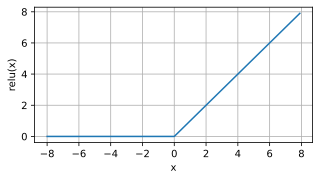

In [ ]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1), dtype=tf.float32)
y = tf.nn.relu(x)
d2l.plot(x.numpy(), y.numpy(), 'x', 'relu(x)', figsize=(5, 2.5))

当输入为负时，ReLU函数的导数为0，而当输入为正时，ReLU函数的导数为1。注意，当输入值精确等于0时，ReLU函数不可导。在此时，我们默认使用左侧的导数，即当输入为0时导数为0。我们可以忽略这种情况，因为输入可能永远都不会是0。这里用上一句古老的谚语，“如果微妙的边界条件很重要，我们很可能是在做数学而非工程”，这个观点正好适用于这里。下面我们绘制ReLU函数的导数。


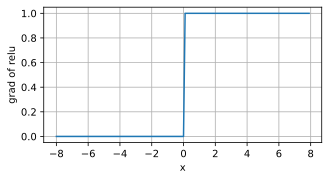

In [ ]:
with tf.GradientTape() as t:
    y = tf.nn.relu(x)
d2l.plot(x.numpy(),
         t.gradient(y, x).numpy(), 'x', 'grad of relu', figsize=(5, 2.5))

使用ReLU的原因是，它求导表现得特别好：要么让参数消失，要么让参数通过。这使得优化表现得更好，并且ReLU减轻了困扰以往神经网络的梯度消失问题（稍后将详细介绍）。

注意，ReLU函数有许多变体，包括*参数化ReLU*（Parameterized ReLU，*pReLU*）函数 :cite:`He.Zhang.Ren.ea.2015`。该变体是为ReLU添加了一个线性项，因此即使参数是负的，某些信息仍然可以通过：

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### sigmoid函数

*sigmoid函数*将定义域在$\mathbb{R}$中的输入变换为区间(0, 1)上的输出。因此，sigmoid通常称为*挤压函数*（Squashing function）：它将范围(-inf, inf)中的任意输入压缩到区间(0, 1)中的某个值：

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

在最早的神经网络中，科学家们感兴趣的是对“激发”或“不激发”的生物神经元进行建模。因此，这一领域的先驱，如人工神经元的发明者麦卡洛克和皮茨。从他们开始就专注于阈值单元。阈值单元在其输入低于某个阈值时取值0，当输入超过阈值时取值1。

当人们的注意力逐渐转移到基于梯度的学习时，sigmoid函数是一个自然的选择，因为它是一个平滑的、可微的阈值单元近似。当我们想要将输出视作二分类问题的概率时，sigmoid仍然被广泛用作输出单元上的激活函数（你可以将sigmoid视为softmax的特例）。然而，sigmoid在隐藏层中已经较少使用，它在大部分时候已经被更简单、更容易训练的ReLU所取代。在后面关于循环神经网络的章节中，我们将描述利用sigmoid单元来控制时序信息流动的结构。

下面，我们绘制sigmoid函数。注意，当输入接近0时，sigmoid函数接近线性变换。


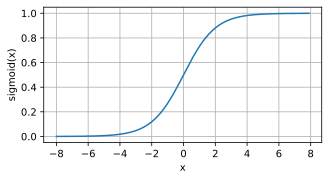

In [ ]:
y = tf.nn.sigmoid(x)
d2l.plot(x.numpy(), y.numpy(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

sigmoid函数的导数为下面的公式：

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$

sigmoid函数的导数图像如下所示。注意，当输入为0时，sigmoid函数的导数达到最大值0.25。当输入在任一方向上远离0点时，导数会更靠近0。


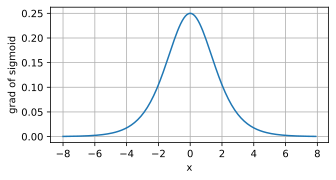

In [ ]:
with tf.GradientTape() as t:
    y = tf.nn.sigmoid(x)
d2l.plot(x.numpy(),
         t.gradient(y, x).numpy(), 'x', 'grad of sigmoid', figsize=(5, 2.5))

### tanh函数

与sigmoid函数类似，tanh(双曲正切)函数也能将其输入压缩转换为区间(-1, 1)上。tanh函数的公式如下：

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

下面我们绘制tanh函数。注意，当输入在0附近时，tanh函数接近线性变换。函数的形状类似于sigmoid函数，不同的是tanh函数关于坐标系原点中心对称。


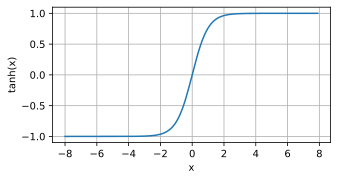

In [ ]:
y = tf.nn.tanh(x)
d2l.plot(x.numpy(), y.numpy(), 'x', 'tanh(x)', figsize=(5, 2.5))

tanh函数的导数是：

$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x).$$

tanh函数的导数图像如下所示。当输入接近0时，tanh函数的导数接近最大值1。与我们在sigmoid函数图像中看到的类似，当输入在任一方向上远离0点时，导数会更靠近0。


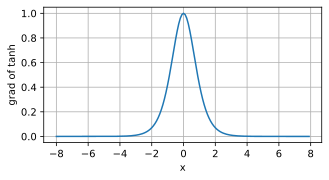

In [ ]:
with tf.GradientTape() as t:
    y = tf.nn.tanh(x)
d2l.plot(x.numpy(),
         t.gradient(y, x).numpy(), 'x', 'grad of tanh', figsize=(5, 2.5))

总结一下，我们现在知道如何结合非线性函数来构建更强表达能力的多层神经网络结构。顺便说一句，你的知识已经让你掌握了一个类似于1990年左右深度学习从业者的工具。在某些方面，你比在20世纪90年代工作的任何人都有优势。这是因为你可以利用功能强大的开源深度学习框架。你只需使用几行代码就可以快速构建模型。在以前，训练这些网络需要研究人员编写数千行的C或Fortran代码。

## 小结

* 多层感知机在输出层和输入层之间增加一个或多个全连接的隐藏层，并通过激活函数转换隐藏层的输出。
* 常用的激活函数包括ReLU函数、sigmoid函数和tanh函数。

## 练习

1. 计算pReLU激活函数的导数。
1. 证明一个仅使用ReLU（或pReLU）的多层感知机构造了一个连续的分段线性函数。
1. 证明$\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$。
1. 假设我们有一个非线性单元，将它一次应用于一个小批量的数据。你认为这会导致什么样的问题？


# 多层感知机的从零开始实现


我们已经在数学上描述了多层感知机（MLP），现在让我们尝试自己实现一个多层感知机。为了与我们之前使用softmax回归（ :numref:`sec_softmax_scratch` ）获得的结果进行比较，我们将继续使用Fashion-MNIST图像分类数据集（ :numref:`sec_fashion_mnist`）。

In [ ]:
!pip install d2l
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

4423680/4422102 [==============================] - 0s 0us/step


## 初始化模型参数

回想一下，Fashion-MNIST中的每个图像由$28 \times 28 = 784$个灰度像素值组成。所有图像共分为10个类别。忽略像素之间的空间结构，我们可以将每个图像视为具有784个输入特征和10个类的简单分类数据集。首先，我们将实现一个具有1个隐藏层的多层感知机，其中包含256个隐藏单元。注意，我们可以将这两个量都视为超参数。通常，我们选择2的幂次方作为层的宽度。因为内存在硬件中的分配和寻址方式，这么做往往可以在计算上更高效。

我们用几个张量来表示我们的参数。注意，对于每一层我们都要记录一个权重矩阵和一个偏置向量。跟以前一样，我们要为这些参数的损失的梯度分配内存。


In [ ]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = tf.Variable(
    tf.random.normal(shape=(num_inputs, num_hiddens), mean=0, stddev=0.01))
b1 = tf.Variable(tf.zeros(num_hiddens))
W2 = tf.Variable(
    tf.random.normal(shape=(num_hiddens, num_outputs), mean=0, stddev=0.01))
b2 = tf.Variable(tf.random.normal([num_outputs], stddev=.01))

params = [W1, b1, W2, b2]

## 激活函数

为了确保我们知道一切是如何工作的，我们将使用最大值函数自己实现ReLU激活函数，而不是直接调用内置的`relu`函数。


In [ ]:
def relu(X):
    return tf.math.maximum(X, 0)

## 模型

因为我们忽略了空间结构，所以我们使用`reshape`将每个二维图像转换为一个长度为`num_inputs`的向量。我们只需几行代码就可以实现我们的模型。


In [ ]:
def net(X):
    X = tf.reshape(X, (-1, num_inputs))
    H = relu(tf.matmul(X, W1) + b1)
    return tf.matmul(H, W2) + b2

## 损失函数

为了确保数值稳定性，同时由于我们已经从零实现过softmax函数（ :numref:`sec_softmax_scratch` ），因此在这里我们直接使用高级API中的内置函数来计算softmax和交叉熵损失。回想一下我们之前在 :numref:`subsec_softmax-implementation-revisited` 中对这些复杂问题的讨论。我们鼓励感兴趣的读者查看损失函数的源代码，以加深对实现细节的了解。


In [ ]:
def loss(y_hat, y):
    return tf.losses.sparse_categorical_crossentropy(y, y_hat, from_logits=True)

## 训练

幸运的是，多层感知机的训练过程实现与softmax回归的训练过程实现完全相同。可以直接调用`d2l`包的`train_ch3`函数（参见 :numref:`sec_softmax_scratch` ），将迭代周期数设置为10，并将学习率设置为0.1.


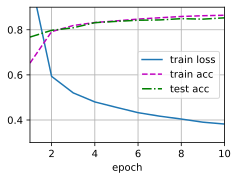

In [ ]:
num_epochs, lr = 10, 0.1
updater = d2l.Updater([W1, W2, b1, b2], lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

为了对学习到的模型进行评估，我们将在一些测试数据上应用这个模型。


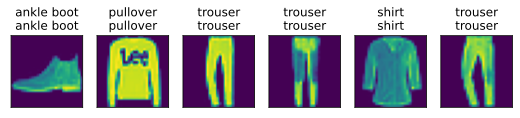

In [ ]:
d2l.predict_ch3(net, test_iter)

## 小结

* 我们看到即使手动实现一个简单的多层感知机也是很容易的。
* 然而，如果有大量的层，从零开始实现多层感知机会变得很麻烦（例如，要命名和记录模型的参数）。

## 练习

1. 在所有其他参数保持不变的情况下，更改超参数`num_hiddens`的值，并查看此超参数的变化对结果有何影响。确定此超参数的最佳值。
1. 尝试添加更多的隐藏层，并查看它对结果有何影响。
1. 改变学习速率会如何影响结果？保持模型结构和其他超参数(包括迭代周期数)不变，学习率设置为多少会带来最好的结果？
1. 通过对所有超参数(学习率、迭代周期数、隐藏层数、每层的隐藏单元数)进行联合优化，可以得到的最佳结果是什么？
1. 描述为什么涉及多个超参数更具挑战性。
1. 如果要构建多个超参数的搜索方法，你能想到的最聪明的策略是什么？


# 多层感知机的简洁实现

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

## 模型

与softmax回归的简洁实现（ :numref:`sec_softmax_concise`）相比，唯一的区别是我们添加了2个全连接层（之前我们只添加了1个全连接层）。第一层是隐藏层，它包含256个隐藏单元并使用了ReLU激活函数。第二层是输出层。


In [ ]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),       # 全连接需要先flatten
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10)])

训练过程实现与我们实现softmax回归时完全相同。这种模块化设计使我们能够将与和模型架构有关的内容独立出来。


In [ ]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)

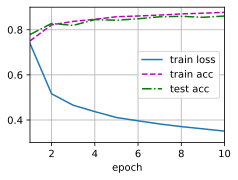

In [ ]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 小结

* 我们可以使用高级API更简洁地实现多层感知机。
* 对于相同的分类问题，多层感知机的实现与softmax回归的实现相同，只是多层感知机的实现里增加了带有激活函数的隐藏层。

## 练习

1. 尝试添加不同数量的隐藏层（也可以修改学习率）。怎么样设置效果最好？
1. 尝试不同的激活函数。哪个效果最好？
1. 尝试不同的方案来初始化权重。什么方法效果最好？


# 模型选择、欠拟合和过拟合

作为机器学习科学家，我们的目标是发现*模式*（pattern）。但是，我们如何才能确定模型是真正发现了一种泛化的模式，而不是简单地记住了数据呢？例如，我们想要在患者的基因数据与痴呆状态之间寻找模式，其中标签是从集合$\{\text{痴呆}, \text{轻度认知障碍}, \text{健康}\}$中提取的。因为基因可以唯一确定每个个体（不考虑双胞胎），所以在这个任务中是有可能记住整个数据集的。

将模型在训练数据上拟合得比在潜在分布中更接近的现象称为*过拟合*，用于对抗过拟合的技术称为*正则化*。在前面的章节中，你可能在用Fashion-MNIST数据集做实验时已经观察到了这种现象。在实验中调整模型结构或超参数时，如果有足够多的神经元、层数和训练迭代周期，你会观察到模型可以在训练集上达到完美的精度。虽然此时测试集的准确性会下降。























## 训练误差和泛化误差

为了进一步讨论这一现象，我们需要了解训练误差和泛化误差。*训练误差*（training error）是指，我们的模型在训练数据集上计算得到的误差。*泛化误差*（generalization error）是指，当我们将模型应用在同样从原始样本的分布中抽取的无限多的数据样本时，我们模型误差的期望。

问题是，我们永远不能准确地计算出泛化误差。这是因为无限多的数据样本是一个虚构的对象。在实际中，我们只能通过将模型应用于一个独立的测试集来*估计*泛化误差，该测试集由从训练集中随机选择并保留的数据样本组成。

下面的三个思考实验将有助于更好地说明这种情况。假设一个大学生正在努力准备期末考试。一个勤奋的学生会努力做好练习，并利用往年的考试题目来测试自己的能力。尽管如此，在过去的考试题目上取得好成绩并不能保证他会在真正考试时发挥出色。例如，学生可能试图通过死记硬背考题的答案来做准备。他甚至可以完全记住过去考试的答案。另一名学生可能会通过试图理解给出某些答案的原因来做准备。在大多数情况下，后一个学生会考得更好。

类似地，考虑一个简单地使用查表法来回答问题的模型。如果允许的输入集合是离散的并且相当小，那么也许在查看许多训练样本后，该方法将执行得很好。但当面对这个模型从未见过的例子时，它表现的可能比随机猜测好不到哪去。这是因为输入空间太大了，远远不可能记住每一个可能输入的对应答案。例如，考虑$28\times28$的灰度图像。如果每个像素可以取$256$个灰度值中的一个，则有$256^{784}$个可能的图像。这意味着指甲大小的低分辨率灰度图像的数量比宇宙中的原子要多得多。即使我们可能遇到这样的数据，我们也不可能存储整个查找表。

最后，考虑尝试根据一些可用的上下文特征对掷硬币的结果（类别0：正面，类别1：反面）进行分类的问题。假设硬币投掷是公平的。无论我们想出什么算法，泛化误差始终是$\frac{1}{2}$。然而，对于大多数算法，我们应该期望训练误差会更低，这取决于运气。考虑数据集{0，1，1，1，0，1}。我们的算法不需要额外的特征，将倾向于总是预测*多数类*，从我们有限的样本来看，它似乎是*1*。在这种情况下，总是预测类1的模型将产生$\frac{1}{3}$的误差，这比我们的泛化误差要好得多。当我们逐渐增加数据量，正面比例明显偏离$\frac{1}{2}$的可能性将会降低，我们的训练误差将与泛化误差相匹配。

### 统计学习理论

由于泛化是机器学习中的基本问题，许多数学家和理论家毕生致力于研究描述这一现象的形式理论。在[同名定理（eponymous theorem）](https://en.wikipedia.org/wiki/Glivenko%E2%80%93Cantelli_theorem)]中，格里文科和坎特利推导出了训练误差收敛到泛化误差的速率。在一系列开创性的论文中，[Vapnik和Chervonenkis](https://en.wikipedia.org/wiki/Vapnik%E2%80%93Chervonenkis_theory)将这一理论扩展到更一般种类的函数。这项工作为统计学习理论奠定了基础。

在有监督中，我们到目前为止都基于一个假设，并且这个假设将贯穿本书的大部分内容。即我们假设训练数据和测试数据都是从*相同的*分布中*独立*提取的。这通常被称为*独立同分布假设*（i.i.d. assumption），这意味着对数据进行采样的过程没有进行“记忆”。换句话说，抽取的第2个样本和第3个样本的相关性并不比抽取的第2个样本和第200万个样本的相关性更强。

要成为一名优秀的机器学习科学家需要有批判性的思考，而且你应该已经从这个假设中找出漏洞，即很容易找出假设失效的情况。如果我们根据从加州大学旧金山分校医学中心的患者数据训练死亡风险预测模型，并将其应用于马萨诸塞州综合医院的患者数据，结果会怎么样？这两个数据的分布可能不完全一样。此外，抽样过程可能与时间有关。比如当我们对微博的主题进行分类时，新闻周期会使得正在讨论的话题产生时间依赖性，这违反了独立性的假设。

有时候我们即使轻微违背独立同分布假设，模型仍将继续运行得非常好。毕竟，几乎所有现实的应用都至少涉及到一些违背独立同分布假设的情况。然而，我们仍然有许多有用的工具已经应用于现实，如人脸识别、语音识别和语言翻译。

有些违背独立同分布假设的行为肯定会带来麻烦。比如，如果我们试图训练一个人脸识别系统，只用来自大学生的人脸数据进行训练，然后想要将其部署为一种工具，用于监测疗养院人群中的老人。这不太可能有效，因为大学生看起来往往与老年人有很大的不同。

在接下来的章节中，我们将讨论因违背独立同分布假设而引起的问题。目前，即使认为独立同分布假设是理所当然的，理解泛化也是一个困难的问题。此外，能够解释深层神经网络泛化性能的理论基础，也仍在继续困扰着学习理论领域最伟大的学者们。

当我们训练模型时，我们试图找到一个能够尽可能拟合训练数据的函数。如果该函数灵活到可以像捕捉真实模式一样容易地捕捉到干扰的模式，那么它可能执行得“太好了”，而不会产生一个对看不见的数据进行很好概括的模型。但我们想要避免这样，或者想要至少能够控制这种现象的出现。深度学习中有许多启发式的技术旨在防止过拟合。

### 模型复杂性

当我们有简单的模型和大量的数据时，我们期望泛化误差与训练误差相近。当我们有更复杂的模型和更少的样本时，我们预计训练误差会下降，但泛化误差会增大。模型复杂性由什么构成是一个复杂的问题。一个模型是否能很好地泛化取决于很多因素。例如，具有更多参数的模型可能被认为更复杂。其参数有更大取值范围的模型可能更为复杂。通常，对于神经网络，我们认为需要更多训练迭代的模型比较复杂，而需要“提前停止”（early stopping）的模型（意味着具有较少训练迭代周期）就不那么复杂。

很难比较本质上不同大类的模型之间（例如，决策树与神经网络）的复杂性。就目前而言，一条简单的经验法则相当有用：**统计学家认为，能够轻松解释任意事实的模型是复杂的，而表达能力有限但仍能很好地解释数据的模型可能更有现实用途。**在理论上，这与波普尔的科学理论的可证伪性标准密切相关：如果一个理论能拟合数据，且有具体的测试可以用来证明它是错误的，那么它就是好的。这一点很重要，因为所有的统计估计都是*事后归纳*，
也就是说，我们在观察事实之后进行估计，因此容易受到相关谬误的影响。目前，我们将把理论放在一边，坚持更切实的问题。

在本节中，为了给你一些直观的印象，我们将重点介绍几个倾向于影响模型泛化的因素：

1. 可调整参数的数量。当可调整参数（有时称为*自由度*）的数量很大时，模型往往更容易过拟合。
1. 参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。
1. 训练样本的数量。即使你的模型很简单，也很容易过拟合只包含一个或两个样本的数据集。但是，过拟合一个数百万个样本数据集需要一个极其灵活的模型。

## 模型选择

在机器学习中，我们通常在评估几个候选模型后选择最终的模型。这个过程叫做*模型选择*。有时，需要进行比较的模型在本质上是完全不同的（比如，决策树与线性模型）。又有时，我们需要比较不同的超参数设置下的同一类模型。

例如，我们要训练多层感知机模型，我们可能希望比较具有不同数量的隐藏层、不同数量的隐藏单元以及不同的的激活函数组合的模型。为了确定候选模型中的最佳模型，我们通常会使用验证集。

### 验证集

原则上，在我们确定所有的超参数之前，我们不应该用到测试集。如果我们在模型选择过程中使用测试数据，可能会有过拟合测试数据的风险。那我们就麻烦大了。如果我们过拟合了我们的训练数据，还有在测试数据上的评估来判断过拟合。但是如果我们过拟合了测试数据，我们又该怎么知道呢？

因此，我们决不能依靠测试数据进行模型选择。然而，我们也不能仅仅依靠训练数据来选择模型，因为我们无法估计训练数据的泛化误差。

在实际应用中，情况变得更加复杂。虽然理想情况下我们只会使用测试数据一次，以评估最好的模型或比较一些模型效果，但现实是，测试数据很少在使用一次后被丢弃。我们很少能有充足的数据来对每一轮实验采用全新测试集。

解决此问题的常见做法是将我们的数据分成三份，除了训练和测试数据集之外，还增加一个*验证数据集*（validation dataset），也叫*验证集*（validation set）。但现实是验证数据和测试数据之间的边界模糊得令人担忧。除非另有明确说明，否则在这本书的实验中，我们实际上是在使用应该被正确地称为训练数据和验证数据的东西，并没有真正的测试数据集。因此，书中每次实验报告的准确度都是验证集准确度，而不是测试集准确度。

### $K$折交叉验证

当训练数据稀缺时，我们甚至可能无法提供足够的数据来构成一个合适的验证集。这个问题的一个流行的解决方案是采用$K$折交叉验证*。这里，原始训练数据被分成$K$个不重叠的子集。然后执行$K$次模型训练和验证，每次在$K-1$个子集上进行训练，并在剩余的一个子集(在该轮中没有用于训练的子集)上进行验证。最后，通过对$K$次实验的结果取平均来估计训练和验证误差。


## 欠拟合还是过拟合？

当我们比较训练和验证误差时，我们要注意两种常见的情况。首先，我们要注意这样的情况：训练误差和验证误差都很严重，但它们之间仅有一点差距。如果模型不能降低训练误差，这可能意味着我们的模型过于简单(即，表达能力不足)，无法捕获我们试图学习的模式。此外，由于我们的训练和验证误差之间的*泛化误差*很小，我们有理由相信可以用一个更复杂的模型降低训练误差。这种现象被称为*欠拟合*（underfitting）。

另一方面，当我们的训练误差明显低于验证误差，表明了严重的*过拟合*（overfitting）。注意，*过拟合*并不总是一件坏事。特别是在深度学习领域，众所周知，最好的预测模型在训练数据上的表现往往比在保留数据上好得多。最终，我们通常更关心验证误差，而不是训练误差和验证误差之间的差距。

我们是否过拟合可能取决于模型复杂性和可用训练数据集的大小，这两个点将在下面进行讨论。

### 模型复杂性

为了说明一些关于过拟合和模型复杂性的经典的直觉，我们给出一个多项式的例子。给定由单个特征$x$和对应实数标签$y$组成的训练数据，我们试图找到下面的$d$阶多项式来估计标签$y$。

$$\hat{y}= \sum_{i=0}^d x^i w_i$$

这只是一个线性回归问题，我们的特征是$x$的幂给出的，模型的权重是$w_i$给出的，偏置是$w_0$给出的（因为对于所有的$x$都有$x^0 = 1$）。由于这只是一个线性回归问题，我们可以使用平方误差作为我们的损失函数。

高阶多项式函数比低阶多项式函数复杂得多。高阶多项式的参数较多，模型函数的选择范围较广。因此在固定训练数据集的情况下，高阶多项式函数相对于低阶多项式的训练误差应该始终更低(最坏情况下是相等的)。事实上，当数据样本包含了$x$的不同值时，函数阶数等于数据样本数量的多项式函数就可以很好地拟合训练集。在 :numref:`fig_capacity_vs_error` 中，我们直观地描述了多项式的阶数和欠拟合与过拟合之间的关系。

### 数据集大小

另一个需要牢记的重要因素是数据集的大小。训练数据集中的样本越少，我们就越有可能（而且更严重）遇到过拟合。随着训练数据量的增加，泛化误差通常会减小。此外，一般来说，更多的数据不会有什么坏处。对于固定的任务和数据分布，通常在模型复杂性和数据集大小之间存在关系。给出更多的数据，我们可能会尝试拟合一个更复杂的模型。能够拟合更复杂的模型可能是有益的。如果没有足够的数据，简单的模型可能更有用。对于许多任务，深度学习只有在有数千个训练样本时才优于线性模型。从一定程度上来说，深度学习目前的成功要归功于互联网公司、廉价存储、互联设备以及经济数字化带来的海量数据集。

## 多项式回归

我们现在可以通过将对数据进行多项式拟合来交互地探索这些概念。

In [ ]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

### 生成数据集

首先，我们需要数据。给定$x$，我们将使用以下三阶多项式来生成训练和测试数据的标签：

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。在优化的过程中，我们通常希望避免非常大的梯度值或损失值。这就是我们将*特征*从$x^i$调整为$\frac{x^i}{i!}$的原因，这样可以避免对于很大的$i$得到特别大的指数值。我们将为训练集和测试集各合成100个样本。


In [ ]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

同样，存储在`poly_features`中的单项式由gamma函数重新缩放，其中$\Gamma(n)=(n-1)!$。从生成的数据集中查看前2个样本。值1是与偏置相对应的常量特征。


In [ ]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [
    tf.constant(x, dtype=tf.float32)
    for x in [true_w, features, poly_features, labels]]

In [ ]:
features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.7699415],
        [0.3306258]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[1.0000000e+00, 7.6994151e-01, 2.9640496e-01, 7.6071493e-02,
         1.4642650e-02, 2.2547969e-03, 2.8934362e-04, 3.1825381e-05,
         3.0629601e-06, 2.6203335e-07, 2.0175035e-08, 1.4121452e-09,
         9.0605766e-11, 5.3662417e-12, 2.9512086e-13, 1.5148386e-14,
         7.2896074e-16, 3.3015124e-17, 1.4122065e-18, 5.7227179e-20],
        [1.0000000e+00, 3.3062580e-01, 5.4656714e-02, 6.0236398e-03,
         4.9789267e-04, 3.2923235e-05, 1.8142118e-06, 8.5689322e-08,
         3.5413878e-09, 1.3009713e-10, 4.3013470e-12, 1.2928512e-13,
         3.5620831e-15, 9.0593582e-17, 2.1394698e-18, 4.7157596e-20,
         9.7446985e-22, 1.8952052e-23, 3.4811320e-25, 6.0576425e-27]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.4294496, 5.307175 ], dtype=float32)>)

### 对模型进行训练和测试

首先让我们实现一个函数来评估模型在给定数据集上的损失。


In [ ]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), tf.size(l).numpy())
    return metric[0] / metric[1]

现在定义训练函数。


In [ ]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

### 三阶多项式函数拟合(正态)

我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。结果表明，该模型能有效降低训练损失和测试损失。学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。


weight: [[ 5.006292   1.2371931 -3.3916209  5.5281343]]


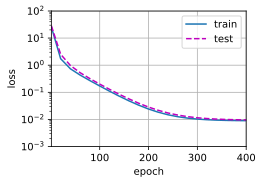

In [ ]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 线性函数拟合(欠拟合)

让我们再看看线性函数拟合。在经历了早期的下降之后，进一步减少该模型的训练损失变得困难。在最后一个迭代周期完成后，训练损失仍然很高。当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。


weight: [[3.6223955 3.3510554]]


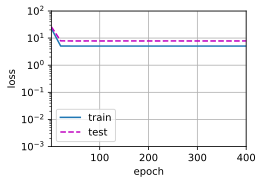

In [ ]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 高阶多项式函数拟合(过拟合)

现在，让我们尝试使用一个过于高阶的多项式来训练模型。在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。虽然训练损失可以有效地降低，但测试损失仍然很高。结果表明，复杂模型对数据造成了过拟合。


weight: [[ 4.9910207   1.2659283  -3.2529984   5.2093253  -0.5376539   1.4058329
   0.09250043  0.57119393  0.13843249 -0.41145393 -0.24273893 -0.29190502
   0.35589123  0.2405052  -0.06012489 -0.37696323  0.43862903 -0.48068604
   0.01506472 -0.09315005]]


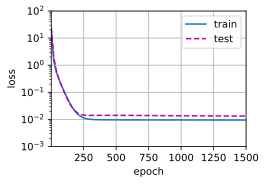

In [ ]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

# 权重衰减

我们已经描述了过拟合的问题，现在我们可以介绍一些正则化模型的技术。我们总是可以通过去收集更多的训练数据来缓解过拟合。但这可能成本很高而且耗时.或者完全超出我们的控制，在短期内不可能做到。假设已经拥有尽可能多的高质量数据，现在我们将重点放在正则化技术上。

回想一下，在多项式回归的例子（ :numref:`sec_model_selection`）中，我们可以通过调整拟合多项式的阶数来限制模型的容量。实际上，限制特征的数量是缓解过拟合的一种常用技术。然而，简单地丢弃特征对于这项工作来说可能过于生硬。我们继续思考多项式回归的例子，考虑高维输入可能发生的情况。多项式对多变量数据的自然扩展称为*单项式*（monomials），也可以说是变量幂的乘积。单项式的阶数是幂的和。例如，$x_1^2 x_2$和$x_3 x_5^2$都是3次单项式。

注意，随着阶数$d$的增长，带有阶数$d$的项数迅速增加。给定$k$个变量，阶数$d$（即$k$多选$d$）的个数为${k - 1 + d} \choose {k - 1}$。即使是阶数上的微小变化，比如从$2$到$3$，也会显著增加我们模型的复杂性。因此，我们经常需要一个更细粒度的工具来调整函数的复杂性。



## 范数与权重衰减

在之前的章节，我们已经描述了$L_2$范数和$L_1$范数，它们是$L_p$范数的特殊情况。
*权重衰减*（通常称为$L_2$正则化），可能是最广泛使用的对参数化机器学习模型进行正则化的技术。这项技术是基于一个基本直觉，即在所有函数$f$中，函数$f = 0$（所有输入都得到值$0$）在某种意义上是最简单的，我们可以通过函数与零的距离来衡量函数的复杂度。但是我们应该如何精确地测量一个函数和零之间的距离呢？没有一个正确的答案。事实上，整个数学分支，包括函数分析和巴拿赫空间理论，都在致力于回答这个问题。

一种简单的方法是通过线性函数$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$中的权重向量的某个范数来度量其复杂性，例如$\| \mathbf{w} \|^2$。要保证权重向量比较小，最常用方法是将其范数作为惩罚项加到最小化损失的问题中。将原来的训练目标*最小化训练标签上的预测损失*，调整为*最小化预测损失和惩罚项之和*。
现在，如果我们的权重向量增长的太大，我们的学习算法可能会更集中于最小化权重范数$\| \mathbf{w} \|^2$。这正是我们想要的。让我们回顾一下 :numref:`sec_linear_regression` 中的线性回归例子。我们的损失由下式给出：

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

回想一下，$\mathbf{x}^{(i)}$是样本$i$的特征，$y^{(i)}$是样本$i$的标签。$(\mathbf{w}, b)$是权重和偏置参数。为了惩罚权重向量的大小，我们必须以某种方式在损失函数中添加$\| \mathbf{w} \|^2$，但是模型应该如何平衡这个新的额外惩罚的损失？实际上，我们通过*正则化常数*$\lambda$来描述这种权衡，这是一个非负超参数，我们使用验证数据拟合：

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2,$$

对于$\lambda = 0$，我们恢复了原来的损失函数。对于$\lambda > 0$，我们限制$\| \mathbf{w} \|$的大小。我们仍然除以$2$：当我们取一个二次函数的导数时，$2$和$1/2$会抵消，以确保更新表达式看起来既漂亮又简单。聪明的读者可能会想知道为什么我们使用平方范数而不是标准范数（即欧几里得距离）。我们这样做是为了便于计算。通过平方$L_2$范数，我们去掉平方根，留下权重向量每个分量的平方和。这使得惩罚的导数很容易计算：导数的和等于和的导数。

此外，你可能会问为什么我们首先使用$L_2$范数，而不是$L_1$范数。事实上，这些选择在整个统计领域中都是有效的和受欢迎的。$L_2$正则化线性模型构成经典的*岭回归*（ridge regression）算法，$L_1$正则化线性回归是统计学中类似的基本模型，通常被称为*套索回归*（lasso regression）。

使用$L_2$范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。在实践中，这可能使它们对单个变量中的观测误差更为鲁棒。相比之下，$L_1$惩罚会导致模型将其他权重清除为零而将权重集中在一小部分特征上。这称为*特征选择*（feature selection），这可能是其他场景下需要的。

使用与 :eqref:`eq_linreg_batch_update` 中的相同符号，$L_2$正则化回归的小批量随机梯度下降更新如下式：

$$
\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}
$$

根据之前章节所讲的，我们根据估计值与观测值之间的差异来更新$\mathbf{w}$。然而，我们同时也在试图将$\mathbf{w}$的大小缩小到零。这就是为什么这种方法有时被称为*权重衰减*。我们仅考虑惩罚项，优化算法在训练的每一步*衰减*权重。与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。较小的$\lambda$值对应较少约束的$\mathbf{w}$，而较大的$\lambda$值对$\mathbf{w}$的约束更大。

是否对相应的偏置$b^2$进行惩罚在不同的实现中会有所不同。在神经网络的不同层中也会有所不同。通常，我们不正则化网络输出层的偏置项。



## 高维线性回归

我们通过一个简单的例子来说明演示权重衰减。


In [ ]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l


首先，我们像以前一样生成一些数据，生成公式如下：

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$

我们选择标签是关于输入的线性函数。标签同时被均值为0，标准差为0.01高斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，并使用一个只包含20个样本的小训练集。


In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 从零开始实现

在下面，我们将从头开始实现权重衰减，只需将$L_2$的平方惩罚添加到原始目标函数中。

### 初始化模型参数

首先，我们将定义一个函数来随机初始化我们的模型参数。


In [ ]:
def init_params():
    w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1,)))
    return [w, b]

### 定义$L_2$范数惩罚

实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。


In [ ]:
def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

### 定义训练代码实现

下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。从 :numref:`chap_linear` 以来，线性网络和平方损失没有变化，所以我们通过`d2l.linreg`和`d2l.squared_loss`导入它们。唯一的变化是损失现在包括了惩罚项。


In [ ]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
                l = loss(net(X), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            d2l.sgd([w, b], grads, lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', tf.norm(w).numpy())

### 不使用正则化进行训练

我们现在用`lambd = 0`禁用权重衰减后运行这个代码。注意，这里训练误差有了减少，但测试误差没有减少。这意味着出现了严重的过拟合。这是过拟合的一个典型例子。


w的L2范数是： 18.883833


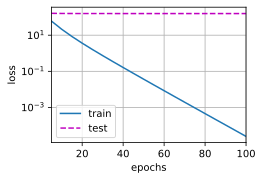

In [ ]:
train(lambd=0)

### 使用权重衰减

下面，我们使用权重衰减来运行代码。注意，在这里训练误差增大，但测试误差减小。这正是我们期望从正则化中得到的效果。


w的L2范数是： 0.51704484


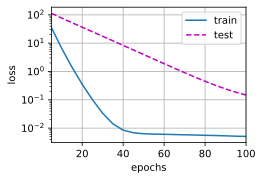

In [ ]:
train(lambd=3)

## 简洁实现

由于权重衰减在神经网络优化中很常用，深度学习框架为了便于使用权重衰减，便将权重衰减集成到优化算法中，以便与任何损失函数结合使用。此外，这种集成还有计算上的好处，允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。由于更新的权重衰减部分仅依赖于每个参数的当前值，因此优化器必须至少接触每个参数一次。


在下面的代码中，我们使用权重衰减超参数`wd`创建一个$L_2$正则化器，并通过`kernel_regularizer`参数将其应用于网络层。


In [ ]:
def train_concise(wd):
    net = tf.keras.models.Sequential()
    net.add(
        tf.keras.layers.Dense(
            1, kernel_regularizer=tf.keras.regularizers.l2(wd)))
    net.build(input_shape=(1, num_inputs))
    w, b = net.trainable_variables
    loss = tf.keras.losses.MeanSquaredError()
    num_epochs, lr = 100, 0.003
    trainer = tf.keras.optimizers.SGD(learning_rate=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # `tf.keras` 需要为自定义训练代码手动添加损失。
                l = loss(net(X), y) + net.losses
            grads = tape.gradient(l, net.trainable_variables)
            trainer.apply_gradients(zip(grads, net.trainable_variables))
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', tf.norm(net.get_weights()[0]).numpy())

这些图看起来和我们从零开始实现权重衰减时的图相同。然而，它们运行得更快，更容易实现，对于更复杂的问题，这一好处将变得更加明显。


w的L2范数： 1.32358


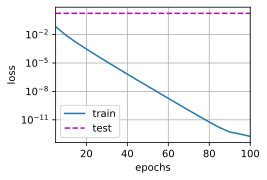

In [ ]:
train_concise(0)

w的L2范数： 0.03323501


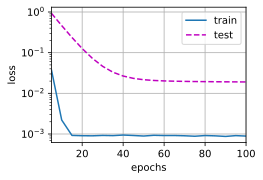

In [ ]:
train_concise(3)

到目前为止，我们只接触到一个简单线性函数的概念。此外，由什么构成一个简单的非线性函数可能是一个更复杂的问题。例如，[再生核希尔伯特空间（RKHS）](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)允许在非线性环境中应用为线性函数引入的工具。不幸的是，基于RKHS的算法往往难以扩展到大型、高维的数据。在这本书中，我们将默认使用简单的启发式方法，即在深层网络的所有层上应用权重衰减。

## 小结

* 正则化是处理过拟合的常用方法。在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。
* 保持模型简单的一个特别的选择是使用$L_2$惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
* 权重衰减功能在深度学习框架的优化器中提供。
* 在同一训练代码实现中，不同的参数集可以有不同的更新行为。

## 练习

1. 在本节的估计问题中使用$\lambda$的值进行实验。绘制训练和测试准确率关于$\lambda$的函数。你观察到了什么？
1. 使用验证集来找到最佳值$\lambda$。它真的是最优值吗？这有关系吗？
1. 如果我们使用$\sum_i |w_i|$作为我们选择的惩罚（$L_1$正则化），那么更新方程会是什么样子？
1. 我们知道$\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$。你能找到类似的矩阵方程吗（见 :numref:`subsec_lin-algebra-norms` 中的弗罗贝尼乌斯范数）？
1. 回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，你还能想出其他什么方法来处理过拟合？
1. 在贝叶斯统计中，我们使用先验和似然的乘积，通过公式$P(w \mid x) \propto P(x \mid w) P(w)$得到后验。如何得到带正则化的$P(w)$？


# 丢弃法（Dropout）



在 :numref:`sec_weight_decay` 中，我们介绍了通过惩罚权重的$L_2$范数来正则化统计模型的经典方法。在概率角度看，我们可以通过以下论证来证明这一技术的合理性：我们已经假设了一个先验，即权重的值取自均值为0的高斯分布。更直观的是，我们可能会说，我们鼓励模型将其权重分散到许多特征中，而不是过于依赖少数潜在的虚假关联。

## 重新审视过拟合

当面对更多的特征而样本不足时，线性模型往往会过度拟合。当给出更多样本而不是特征，我们通常可以指望线性模型不会过拟合。不幸的是，线性模型泛化的可靠性是有代价的。简单地说，线性模型没有考虑到特征之间的交互作用。对于每个特征，线性模型必须指定正的或负的权重，而忽略上下文。

在传统说法中，泛化性和灵活性之间的这种基本权衡被描述为*偏差-方差权衡*（bias-variance tradeoff）。线性模型有很高的偏差：它们只能表示一小类函数。然而，这些模型的方差很低：它们在不同的随机数据样本上给出了相似的结果。

深度神经网络位于偏差-方差谱的另一端。与线性模型不同，神经网络并不局限于单独查看每个特征。它们可以学习特征之间的交互。例如，它们可能推断“尼日利亚”和“西联汇款”一起出现在电子邮件中表示垃圾邮件，但单独出现则不表示垃圾邮件。

即使我们有比特征多得多的样本，深度神经网络也有可能过拟合。2017年，一组研究人员通过在随机标记的图像上训练深度网络。这展示了神经网络的极大灵活性。因为没有任何真实的模式将输入和输出联系起来，但他们发现，通过随机梯度下降优化的神经网络可以完美地标记训练集中的每一幅图像。想一想这意味着什么。如果标签是随机均匀分配的，并且有10个类别，那么在保留数据上没有分类器会取得高于10%的准确率。这里的泛化差距高达90%。如果我们的模型具有这么强的表达能力，以至于它们可以如此严重地过拟合，那么我们指望在什么时候它们不会过拟合呢？

深度网络有着令人费解的泛化性质，而这种泛化性质的数学基础仍然是悬而未决的研究问题，我们鼓励面向理论的读者更深入地研究这个主题。目前，我们转向对实际工具的探究，这些工具倾向于经验上改进深层网络的泛化性。

## 扰动的鲁棒性

让我们简单地思考一下我们对一个好的预测模型的期待。我们期待它能在看不见的数据上有很好的表现。经典泛化理论认为，为了缩小训练和测试性能之间的差距，我们应该以简单的模型为目标。简单性以较小维度的形式出现。我们在 :numref:`sec_model_selection` 讨论线性模型的单项式函数时探讨了这一点。此外，正如我们在 :numref:`sec_weight_decay` 中讨论权重衰减（$L_2$正则化）时看到的那样，参数的范数也代表了一种有用的简单性度量。简单性的另一个有用角度是平滑性，即函数不应该对其输入的微小变化敏感。例如，当我们对图像进行分类时，我们预计向像素添加一些随机噪声应该是基本无影响的。

1995年，克里斯托弗·毕晓普证明了具有输入噪声的训练等价于Tikhonov正则化 :cite:`Bishop.1995` ，从而将这一观点正式化。这项工作在要求函数光滑(因而简单)和要求它对输入中的扰动具有适应性之间有了明确的数学联系。

然后，在2014年，斯里瓦斯塔瓦等人 :cite:`Srivastava.Hinton.Krizhevsky.ea.2014` 还就如何将毕晓普的想法应用于网络的内部层提出了一个聪明的想法。**在训练过程中，他们建议在计算后续层之前向网络的每一层注入噪声。他们意识到，当训练一个有多层的深层网络时，注入噪声只会在输入-输出映射上增强平滑性。**

**他们的想法被称为*丢弃法*（dropout），dropout在正向传播过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的标准技术。**这种方法之所以被称为 *dropout* ，因为我们从表面上看是在训练过程中丢弃（drop out）一些神经元。
在整个训练过程的每一次迭代中，dropout包括在计算下一层之前将当前层中的一些节点置零。

需要说明的是，我们将自己的叙述与毕晓普联系起来。关于dropout的原始论文出人意料地通过一个有性繁殖类比提供了直觉。作者认为，神经网络过拟合的特征是每一层都依赖于前一层激活值的特定模式，称这种情况为“共适应性”。他们声称，dropout会破坏共适应性，就像有性生殖会破坏共适应的基因一样。

那么关键的挑战就是如何注入这种噪声。一种想法是以一种*无偏*的方式注入噪声。这样在固定住其他层时，每一层的期望值等于没有噪音时的值。

在毕晓普的工作中，他将高斯噪声添加到线性模型的输入中。在每次训练迭代中，他将从均值为零的分布$\epsilon \sim \mathcal{N}(0,\sigma^2)$采样噪声添加到输入$\mathbf{x}$，从而产生扰动点$\mathbf{x}' = \mathbf{x} + \epsilon$。预期是$E[\mathbf{x}'] = \mathbf{x}$。

在标准dropout正则化中，通过按保留（未丢弃）的节点的分数进行归一化来消除每一层的偏差。换言之，每个中间激活值$h$以*丢弃概率*$p$由随机变量$h'$替换，如下所示：

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ 概率为 } p \\
    \frac{h}{1-p} & \text{ 其他情况}
\end{cases}
\end{aligned}
$$

根据设计，期望值保持不变，即$E[h'] = h$。

## 实践中的dropout

回想一下 :numref:`fig_mlp` 中带有一个隐藏层和5个隐藏单元的多层感知机。当我们将dropout应用到隐藏层，以$p$的概率将隐藏单元置为零时，结果可以看作是一个只包含原始神经元子集的网络。在 :numref:`fig_dropout2` 中，删除了$h_2$和$h_5$。因此，输出的计算不再依赖于$h_2$或$h_5$，并且它们各自的梯度在执行反向传播时也会消失。这样，输出层的计算不能过度依赖于$h_1, \ldots, h_5$的任何一个元素。

![dropout前后的多层感知机。](http://d2l.ai/_images/dropout2.svg)
:label:`fig_dropout2`

通常，我们在测试时禁用dropout。给定一个训练好的模型和一个新的样本，我们不会丢弃任何节点，因此不需要标准化。然而，也有一些例外：一些研究人员使用测试时的dropout作为估计神经网络预测的“不确定性”的启发式方法：如果预测在许多不同的dropout掩码上都是一致的，那么我们可以说网络更有自信心。

## 从零开始实现

要实现单层的dropout函数，我们必须从伯努利（二元）随机变量中提取与我们的层的维度一样多的样本，其中随机变量以概率$1-p$取值$1$（保持），以概率$p$取值$0$（丢弃）。实现这一点的一种简单方式是首先从均匀分布$U[0, 1]$中抽取样本。那么我们可以保留那些对应样本大于$p$的节点，把剩下的丢弃。

在下面的代码中，我们实现了一个`dropout_layer`函数，该函数以`dropout`的概率丢弃张量输入`X`中的元素，如上所述重新缩放剩余部分：将剩余部分除以`1.0-dropout`。


In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃。
    if dropout == 1:
        return tf.zeros_like(X)
    # 在本情况中，所有元素都被保留。
    if dropout == 0:
        return X
    mask = tf.random.uniform(shape=tf.shape(X), minval=0,
                             maxval=1) < 1 - dropout
    return tf.cast(mask, dtype=tf.float32) * X / (1.0 - dropout)

我们可以通过几个例子来测试`dropout_layer`函数。在下面的代码行中，我们将输入`X`通过dropout操作，丢弃概率分别为0、0.5和1。


In [ ]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  0.  4.  6.  8.  0.  0. 14.]
 [ 0. 18. 20. 22. 24. 26.  0. 30.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


### 定义模型参数

同样，我们使用 :numref:`sec_fashion_mnist` 中引入的Fashion-MNIST数据集。我们定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元。


In [ ]:
num_outputs, num_hiddens1, num_hiddens2 = 10, 256, 256

### 定义模型

下面的模型将dropout应用于每个隐藏层的输出（在激活函数之后）。我们可以分别为每一层设置丢弃概率。
一种常见的技巧是在靠近输入层的地方设置较低的丢弃概率。
下面，我们将第一个和第二个隐藏层的丢弃概率分别设置为0.2和0.5。我们确保dropout只在训练期间有效。


In [ ]:
dropout1, dropout2 = 0.2, 0.5

class Net(tf.keras.Model):
    def __init__(self, num_outputs, num_hiddens1, num_hiddens2):
        super().__init__()
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden1 = tf.keras.layers.Dense(num_hiddens1, activation='relu')
        self.hidden2 = tf.keras.layers.Dense(num_hiddens2, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_outputs)

    def call(self, inputs, training=None):
        x = self.input_layer(inputs)
        x = self.hidden1(x)
        # 只有在训练模型时才使用dropout
        if training:
            # 在第一个全连接层之后添加一个dropout层
            x = dropout_layer(x, dropout1)
        x = self.hidden2(x)
        if training:
            # 在第二个全连接层之后添加一个dropout层
            x = dropout_layer(x, dropout2)
        x = self.output_layer(x)
        return x

net = Net(num_outputs, num_hiddens1, num_hiddens2)

### 训练和测试

这类似于前面描述的多层感知机训练和测试。


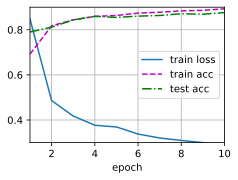

In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 简洁实现

对于高级API，我们所需要做的就是在每个全连接层之后添加一个`Dropout`层，将丢弃概率作为唯一的参数传递给它的构造函数。在训练过程中，`Dropout`层将根据指定的丢弃概率随机丢弃上一层的输出（相当于下一层的输入）。当不处于训练模式时，`Dropout`层仅在测试时传递数据。


In [ ]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    # 在第一个全连接层之后添加一个dropout层
    tf.keras.layers.Dropout(dropout1),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    # 在第二个全连接层之后添加一个dropout层
    tf.keras.layers.Dropout(dropout2),
    tf.keras.layers.Dense(10),])

接下来，我们对模型进行训练和测试。


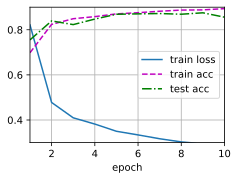

In [ ]:
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 小结

* 除了控制权重向量的维数和大小之外，dropout也是避免过拟合的另一种工具。它们通常是联合使用的。
* dropout将激活值$h$替换为具有期望值$h$的随机变量。
* dropout仅在训练期间使用。

## 练习

1. 如果更改第一层和第二层的dropout概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？设计一个实验来回答这些问题，定量描述你的结果，并总结定性的结论。
1. 增加迭代周期数，并将使用dropout和不使用dropout时获得的结果进行比较。
1. 当应用或不应用dropout时，每个隐藏层中激活值的方差是多少？绘制一个曲线图，以显示这两个模型的每个隐藏层中激活值的方差是如何随时间变化的。
1. 为什么在测试时通常不使用dropout？
1. 以本节中的模型为例，比较使用dropout和权重衰减的效果。如果同时使用dropout和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？
1. 如果我们将dropout应用到权重矩阵的各个权重，而不是激活值，会发生什么？
1. 发明另一种用于在每一层注入随机噪声的技术，该技术不同于标准的dropout技术。你能否开发一种在Fashion-MNIST数据集(对于固定结构)上性能优于dropout的方法？


# 正向传播、反向传播和计算图




到目前为止，我们已经用小批量随机梯度下降训练了我们的模型。然而，当我们实现该算法时，我们只考虑了通过模型 *正向传播*（forward propagation）所涉及的计算。在计算梯度时，我们只调用了深度学习框架提供的反向传播函数。

梯度的自动计算（自动微分）大大简化了深度学习算法的实现。在自动微分之前，即使是对复杂模型的微小调整也需要手工重新计算复杂的导数。学术论文也不得不分配大量页面来推导更新规则。我们必须继续依赖于自动微分，这样我们就可以专注于有趣的部分，但是如果你想超过对深度学习的浅薄理解，你应当知道这些梯度是如何计算出来的。

在本节中，我们将深入探讨 *反向传播*（backward propagation 或 backpropagation）的细节。为了传达对这些技术及其实现的一些见解，我们依赖一些基本的数学和计算图。首先，我们将重点放在带权重衰减（$L_2$正则化）的单隐藏层多层感知机上。

## 正向传播

*正向传播*（forward propagation或forward pass）指的是：按顺序（从输入层到输出层）计算和存储
神经网络中每层的结果。

我们将一步步研究单隐藏层神经网络的机制，为了简单起见，我们假设输入样本是 $\mathbf{x}\in \mathbb{R}^d$，并且我们的隐藏层不包括偏置项。这里的中间变量是：

$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x},$$

其中$\mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$是隐藏层的权重参数。然后将中间变量$\mathbf{z}\in \mathbb{R}^h$通过激活函数$\phi$后，我们得到长度为$h$的隐藏激活向量：

$$\mathbf{h}= \phi (\mathbf{z}).$$

隐藏变量$\mathbf{h}$也是一个中间变量。假设输出层的参数只有权重$\mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$，我们可以得到输出层变量，它是一个长度为$q$的向量：

$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}.$$

假设损失函数为$l$，样本标签为$y$，我们可以计算单个数据样本的损失项，

$$L = l(\mathbf{o}, y).$$

根据$L_2$正则化的定义，给定超参数$\lambda$，正则化项为

$$s = \frac{\lambda}{2} \left(\|\mathbf{W}^{(1)}\|_F^2 + \|\mathbf{W}^{(2)}\|_F^2\right),$$
:eqlabel:`eq_forward-s`

其中，矩阵的弗罗贝尼乌斯范数是将矩阵展平为向量后应用的$L_2$范数。最后，模型在给定数据样本上的正则化损失为：

$$J = L + s.$$

在下面的讨论中，我们将$J$称为*目标函数*。

## 正向传播计算图

绘制*计算图*有助于我们可视化计算中操作符和变量的依赖关系。 :numref:`fig_forward` 是与上述简单网络相对应的计算图，其中正方形表示变量，圆圈表示操作符。左下角表示输入，右上角表示输出。注意显示数据流的箭头方向主要是向右和向上的。

![正向传播的计算图](http://d2l.ai/_images/forward.svg)
:label:`fig_forward`

## 反向传播

*反向传播*指的是计算神经网络参数梯度的方法。简言之，该方法根据微积分中的*链式规则*，按相反的顺序从输出层到输入层遍历网络。该算法存储了计算某些参数梯度时所需的任何中间变量（偏导数）。假设我们有函数$\mathsf{Y}=f(\mathsf{X})$和$\mathsf{Z}=g(\mathsf{Y})$，其中输入和输出$\mathsf{X}, \mathsf{Y}, \mathsf{Z}$是任意形状的张量。利用链式法则，我们可以计算$\mathsf{Z}$关于$\mathsf{X}$的导数

$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \text{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right).$$

在这里，我们使用$\text{prod}$运算符在执行必要的操作（如换位和交换输入位置）后将其参数相乘。对于向量，这很简单：它只是矩阵-矩阵乘法。对于高维张量，我们使用适当的对应项。运算符$\text{prod}$指代了所有的这些符号。

回想一下，在计算图 :numref:`fig_forward` 中的单隐藏层简单网络的参数是$\mathbf{W}^{(1)}$和$\mathbf{W}^{(2)}$。反向传播的目的是计算梯度$\partial J/\partial \mathbf{W}^{(1)}$和$\partial J/\partial \mathbf{W}^{(2)}$。为此，我们应用链式法则，依次计算每个中间变量和参数的梯度。计算的顺序与正向传播中执行的顺序相反，因为我们需要从计算图的结果开始，并朝着参数的方向努力。第一步是计算目标函数$J=L+s$相对于损失项$L$和正则项$s$的梯度。

$$\frac{\partial J}{\partial L} = 1 \; \text{and} \; \frac{\partial J}{\partial s} = 1.$$

接下来，我们根据链式法则计算目标函数关于输出层变量$\mathbf{o}$的梯度：

$$
\frac{\partial J}{\partial \mathbf{o}}
= \text{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \mathbf{o}}\right)
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q.
$$

接下来，我们计算正则化项相对于两个参数的梯度：

$$\frac{\partial s}{\partial \mathbf{W}^{(1)}} = \lambda \mathbf{W}^{(1)}
\; \text{and} \;
\frac{\partial s}{\partial \mathbf{W}^{(2)}} = \lambda \mathbf{W}^{(2)}.$$

现在我们可以计算最接近输出层的模型参数的梯度$\partial J/\partial \mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$。使用链式法则得出：

$$\frac{\partial J}{\partial \mathbf{W}^{(2)}}= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right)= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}.$$
:eqlabel:`eq_backprop-J-h`

为了获得关于$\mathbf{W}^{(1)}$的梯度，我们需要继续沿着输出层到隐藏层反向传播。关于隐藏层输出的梯度$\partial J/\partial \mathbf{h} \in \mathbb{R}^h$由下式给出：

$$
\frac{\partial J}{\partial \mathbf{h}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{h}}\right)
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}.
$$

由于激活函数$\phi$是按元素计算的，计算中间变量$\mathbf{z}$的梯度$\partial J/\partial \mathbf{z} \in \mathbb{R}^h$需要使用按元素乘法运算符，我们用$\odot$表示：

$$
\frac{\partial J}{\partial \mathbf{z}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{z}}\right)
= \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right).
$$

最后，我们可以得到最接近输入层的模型参数的梯度$\partial J/\partial \mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$。根据链式法则，我们得到：

$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right)
= \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}.
$$

## 训练神经网络

在训练神经网络时，正向传播和后向传播相互依赖。对于正向传播，我们沿着依赖的方向遍历计算图并计算其路径上的所有变量。然后将这些用于反向传播，其中计算顺序与计算图的相反。

以上述简单网络为例进行说明。一方面，在正向传播期间计算正则项 :eqref:`eq_forward-s` 取决于模型参数$\mathbf{W}^{(1)}$和$\mathbf{W}^{(2)}$的当前值。它们是由优化算法根据最近迭代的反向传播给出的。另一方面，反向传播期间参数 :eqref:`eq_backprop-J-h` 的梯度计算取决于由正向传播给出的隐藏变量$\mathbf{h}$的当前值。

因此，在训练神经网络时，在初始化模型参数后，我们交替使用正向传播和反向传播，利用反向传播给出的梯度来更新模型参数。注意，反向传播复用正向传播中存储的中间值，以避免重复计算。带来的影响之一是我们需要保留中间值，直到反向传播完成。这也是为什么训练比单纯的预测需要更多的内存（显存）的原因之一。此外，这些中间值的大小与网络层的数量和批量的大小大致成正比。因此，使用更大的批量来训练更深层次的网络更容易导致*内存（显存）不足*（out of memory）错误。

## 小结

* 正向传播在神经网络定义的计算图中按顺序计算和存储中间变量。它的顺序是从输入层到输出层。
* 反向传播按相反的顺序计算和存储神经网络的中间变量和参数的梯度。
* 在训练深度学习模型时，正向传播和反向传播是相互依赖的。
* 训练比预测需要更多的内存（显存）。

## 练习

1. 假设一些标量函数$\mathbf{X}$的输入$\mathbf{X}$是$n \times m$矩阵。$f$相对于$\mathbf{X}$的梯度维数是多少？
1. 向本节中描述的模型的隐藏层添加偏置项（不需要在正则化项中包含偏置项）。
    1. 画出相应的计算图。
    1. 推导正向和后向传播方程。
1. 计算本节所描述的模型，用于训练和预测的内存占用。
1. 假设你想计算二阶导数。计算图发生了什么？你预计计算需要多长时间？
1. 假设计算图对于你的GPU来说太大了。
    1. 你能把它划分到多个GPU上吗？
    1. 与小批量训练相比，有哪些优点和缺点？

[Discussions](https://discuss.d2l.ai/t/1816)


# 数值稳定性和模型初始化




到目前为止，我们实现的每个模型都是根据某个预先指定的分布来初始化模型的参数。直到现在，我们认为初始化方案是理所当然的，忽略了如何做出这些选择的细节。你甚至可能会觉得，初始化方案的选择并不是特别重要。相反，初始化方案的选择在神经网络学习中起着非常重要的作用，它对保持数值稳定性至关重要。此外，这些选择可以与非线性激活函数的选择以有趣的方式结合在一起。我们选择哪个函数以及如何初始化参数可以决定优化算法收敛的速度有多快。糟糕选择可能会导致我们在训练时遇到梯度爆炸或梯度消失。在本节中，我们将更详细地探讨这些主题，并讨论一些有用的启发式方法。你会发现这些启发式方法在你的整个深度学习生涯中都很有用。

## 梯度消失和梯度爆炸

考虑一个具有$L$层、输入$\mathbf{x}$和输出$\mathbf{o}$的深层网络。每一层$l$由变换$f_l$定义，该变换的参数为权重$\mathbf{W}^{(l)}$，其隐藏变量是$\mathbf{h}^{(l)}$（令 $\mathbf{h}^{(0)} = \mathbf{x}$）。我们的网络可以表示为：

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \text{ 因此 } \mathbf{o} = f_L \circ \ldots \circ f_1(\mathbf{x}).$$

如果所有隐藏变量和输入都是向量，我们可以将$\mathbf{o}$关于任何一组参数$\mathbf{W}^{(l)}$的梯度写为下式：

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\mathrm{def}}{=}} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\mathrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\mathrm{def}}{=}}.$$

换言之，该梯度是$L-l$个矩阵$\mathbf{M}^{(L)} \cdot \ldots \cdot \mathbf{M}^{(l+1)}$与梯度向量 $\mathbf{v}^{(l)}$的乘积。因此，我们容易受到数值下溢问题的影响，当将太多的概率乘在一起时，这些问题经常会出现。在处理概率时，一个常见的技巧是切换到对数空间，即将数值表示的压力从尾数转移到指数。不幸的是，我们上面的问题更为严重：最初，矩阵 $\mathbf{M}^{(l)}$ 可能具有各种各样的特征值。他们可能很小，也可能很大，他们的乘积可能*非常大*，也可能*非常小*。

不稳定梯度带来的风险不止在于数值表示。不稳定梯度也威胁到我们优化算法的稳定性。我们可能面临一些问题。
要么是 *梯度爆炸*（gradient exploding）问题：参数更新过大，破坏了模型的稳定收敛；
要么是 *梯度消失*（gradient vanishing）问题：参数更新过小，在每次更新时几乎不会移动，导致无法学习。

### 梯度消失

导致梯度消失问题的一个常见的原因是跟在每层的线性运算之后的激活函数$\sigma$。从历史上看，sigmoid函数$1/(1 + \exp(-x))$（ :numref:`sec_mlp` 提到过）很流行，因为它类似于阈值函数。由于早期的人工神经网络受到生物神经网络的启发，神经元要么完全激活要么完全不激活（就像生物神经元）的想法很有吸引力。让我们仔细看看sigmoid函数为什么会导致梯度消失。


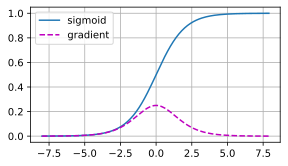

In [ ]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

x = tf.Variable(tf.range(-8.0, 8.0, 0.1))
with tf.GradientTape() as t:
    y = tf.nn.sigmoid(x)
d2l.plot(x.numpy(), [y.numpy(), t.gradient(y, x).numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

正如你所看到的，当它的输入很大或是很小时，sigmoid函数的梯度都会消失。此外，当反向传播通过许多层时，除非我们在刚刚好的地方，这些地方sigmoid函数的输入接近于零，否则整个乘积的梯度可能会消失。当我们的网络有很多层时，除非我们很小心，否则在某一层可能会切断梯度。事实上，这个问题曾经困扰着深度网络的训练。因此，更稳定（但在神经科学的角度看起来不太合理）的ReLU系列函数已经成为从业者的默认选择。

### 梯度爆炸

相反的问题，当梯度爆炸时，可能同样令人烦恼。为了更好地说明这一点，我们生成100个高斯随机矩阵，并将它们与某个初始矩阵相乘。对于我们选择的尺度（方差$\sigma^2=1$），矩阵乘积发生爆炸。当这种情况是由于深度网络的初始化所导致时，我们没有机会让梯度下降优化器收敛。


In [ ]:
M = tf.random.normal((4, 4))
print('一个矩阵 \n', M)
for i in range(100):
    M = tf.matmul(M, tf.random.normal((4, 4)))

print('乘以100个矩阵后\n', M.numpy())

一个矩阵 
 tf.Tensor(
[[ 1.144319   -1.3104796  -0.21178718 -0.7396453 ]
 [-0.09072351  0.16602224 -0.05988737 -0.68394053]
 [ 0.01444124  0.21759437 -1.5872679   0.80508965]
 [-0.10451052 -0.34821364  0.8449392   0.8127946 ]], shape=(4, 4), dtype=float32)
乘以100个矩阵后
 [[-1.4402216e+23  2.8945148e+22 -4.8302786e+22 -2.0558021e+23]
 [-1.6760042e+23  3.3684525e+22 -5.6210075e+22 -2.3923449e+23]
 [ 9.2085426e+22 -1.8507258e+22  3.0883871e+22  1.3144409e+23]
 [ 2.7308999e+23 -5.4884635e+22  9.1590246e+22  3.8981479e+23]]


### 打破对称性

神经网络设计中的另一个问题是其参数化所固有的对称性。假设我们有一个简单的多层感知机，它有一个隐藏层和两个隐藏单元。在这种情况下，我们可以对第一层的权重$\mathbf{W}^{(1)}$进行重排列，并且同样对输出层的权重进行重排列，可以获得相同的函数。第一个隐藏单元与第二个隐藏单元没有什么特别的区别。换句话说，我们在每一层的隐藏单元之间具有排列对称性。

这不仅仅是理论上的麻烦。考虑前述具有两个隐藏单元的单隐藏层多层感知机。为便于说明，假设输出层将两个隐藏单元转换为仅一个输出单元。想象一下，如果我们将隐藏层的所有参数初始化为$\mathbf{W}^{(1)} = c$，$c$为常量，会发生什么情况。在这种情况下，在正向传播期间，两个隐藏单元采用相同的输入和参数，产生相同的激活，该激活被送到输出单元。在反向传播期间，根据参数$\mathbf{W}^{(1)}$对输出单元进行微分，得到一个梯度，其元素都取相同的值。因此，在基于梯度的迭代(例如，小批量随机梯度下降)之后，$\mathbf{W}^{(1)}$的所有元素仍然采用相同的值。这样的迭代永远不会打破对称性，我们可能永远也无法实现网络的表达能力。隐藏层的行为就好像只有一个单元。请注意，虽然小批量随机梯度下降不会打破这种对称性，但dropout正则化可以。

## 参数初始化

解决（或至少减轻）上述问题的一种方法是仔细地进行初始化。优化期间的注意和适当的正则化可以进一步提高稳定性。

### 默认初始化

在前面的部分中，例如在 :numref:`sec_linear_concise` 中，我们使用正态分布来初始化权重值。如果我们不指定初始化方法，框架将使用默认的随机初始化方法，对于中等规模的问题，这种方法通常很有效。

### Xavier初始化
:label:`subsec_xavier`

让我们看看某些*没有非线性*的全连接层输出(例如，隐藏变量)$o_{i}$的尺度分布。
对于该层$n_\mathrm{in}$输入$x_j$及其相关权重$w_{ij}$，输出由下式给出

$$o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j.$$

权重$w_{ij}$都是从同一分布中独立抽取的。此外，让我们假设该分布具有零均值和方差$\sigma^2$。请注意，这并不意味着分布必须是高斯的，只是均值和方差需要存在。现在，让我们假设层$x_j$的输入也具有零均值和方差$\gamma^2$，并且它们独立于$w_{ij}$并且彼此独立。在这种情况下，我们可以按如下方式计算$o_i$的平均值和方差：

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] \\&= 0, \\
    \mathrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

保持方差不变的一种方法是设置$n_\mathrm{in} \sigma^2 = 1$。现在考虑反向传播过程，我们面临着类似的问题，尽管梯度是从更靠近输出的层传播的。使用与正向传播相同的推理，我们可以看到，除非$n_\mathrm{out} \sigma^2 = 1$，否则梯度的方差可能会增大，其中$n_\mathrm{out}$是该层的输出的数量。这使我们进退两难：我们不可能同时满足这两个条件。相反，我们只需满足：

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ 或等价于 }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}.
\end{aligned}
$$

这就是现在标准且实用的*Xavier初始化*的基础，它以其提出者 :cite:`Glorot.Bengio.2010` 第一作者的名字命名。通常，Xavier初始化从均值为零，方差$\sigma^2 = \frac{2}{n_\mathrm{in} + n_\mathrm{out}}$的高斯分布中采样权重。我们也可以利用Xavier的直觉来选择从均匀分布中抽取权重时的方差。注意均匀分布$U(-a, a)$的方差为$\frac{a^2}{3}$。将$\frac{a^2}{3}$代入到$\sigma^2$的条件中，将得到初始化的建议：

$$U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right).$$

尽管上述数学推理中，不存在非线性的假设在神经网络中很容易被违反，但Xavier初始化方法在实践中被证明是有效的。

### 额外内容

上面的推理仅仅触及了现代参数初始化方法的皮毛。深度学习框架通常实现十几种不同的启发式方法。此外，参数初始化一直是深度学习基础研究的热点领域。其中包括专门用于参数绑定(共享)、超分辨率、序列模型和其他情况的启发式算法。例如，Xiao等人演示了通过使用精心设计的初始化方法 :cite:`Xiao.Bahri.Sohl-Dickstein.ea.2018` ，可以无需结构上的技巧而训练10000层神经网络的可能性。

如果你对该主题感兴趣，我们建议你深入研究本模块的内容，阅读提出并分析每种启发式方法的论文，然后探索有关该主题的最新出版物。也许你会偶然发现甚至发明一个聪明的想法，并为深度学习框架提供一个实现。

## 小结

* 梯度消失和爆炸是深度网络中常见的问题。在参数初始化时需要非常小心，以确保梯度和参数可以得到很好的控制。
* 需要用启发式的初始化方法来确保初始梯度既不太大也不太小。
* ReLU激活函数缓解了梯度消失问题，这样可以加速收敛。
* 随机初始化是保证在进行优化前打破对称性的关键。
* Xavier初始化表明，对于每一层，输出的方差不受输入数量的影响，任何梯度的方差不受输出数量的影响。

## 练习

1. 除了多层感知机的排列对称性之外，你能设计出其他神经网络可能会表现出对称性且需要被打破的情况吗？
2. 我们是否可以将线性回归或softmax回归中的所有权重参数初始化为相同的值？
3. 在相关资料中查找两个矩阵乘积特征值的解析界。这对确保梯度条件合适有什么启示？
4. 如果我们知道某些项是发散的，我们能在事后修正吗？看看关于分层自适应速率缩放的论文 :cite:`You.Gitman.Ginsburg.2017` 。


# 环境和分布偏移



在前面的部分中，我们学习了机器学习的许多实际应用，将模型拟合各种数据集。然而，我们从来没有思考数据最初从哪里来，或者我们计划最终如何处理模型的输出。通常情况下，拥有数据的机器学习开发人员急于开发模型，而不停下来考虑这些基本问题。

许多失败的机器学习部署都可以追溯到这种方式。有时，根据测试集的准确度衡量，模型表现得非常出色，但是当数据分布突然改变时，模型在部署中会出现灾难性的失败。更隐蔽的是，有时模型的部署本身就是扰乱数据分布的催化剂。例如，我们训练了一个模型来预测谁将偿还贷款或违约，发现申请人选择的鞋子与违约风险相关（牛津鞋表示偿还，运动鞋表示违约）。此后，我们可能倾向于向所有穿着牛津鞋的申请人发放贷款，并拒绝所有穿着运动鞋的申请人。

在这种情况下，在这种情况下，我们从模式识别到决策的未经深思熟虑地跳跃，以及我们未能批判性地考虑环境可能会带来灾难性的后果。首先，一旦我们开始根据鞋类做出决定，顾客就会理解并改变他们的行为。不久，所有的申请者都会穿牛津鞋，而信用度却没有相应的提高。花点时间来理解这一点，因为机器学习的许多应用中都存在类似的问题：通过将基于模型的决策引入环境，我们可能会破坏模型。

虽然我们不可能在一节中完整地讨论这些主题，但我们的目的是揭示一些常见的问题，并激发必要的批判性思考，以便及早发现这些情况，减轻损害，并负责任地使用机器学习。有些解决方案很简单（要求“正确”的数据），有些在技术上很困难（实施强化学习系统），还有一些解决方案要求我们完全跳出统计预测的领域，努力解决与算法的伦理应用有关的棘手哲学问题。

## 分布偏移的类型

首先，我们坚持使用被动预测设置，考虑到数据分布可能发生变化的各种方式，以及为挽救模型性能可能采取的措施。在一个经典的设置中，我们假设我们的训练数据是从某个分布$p_S(\mathbf{x},y)$中采样的，但是我们的测试数据将包含从不同分布$p_T(\mathbf{x},y)$中抽取的未标记样本。我们必须面对一个清醒的现实。如果没有任何关于$p_S$和$p_T$之间相互关系的假设，学习到一个鲁棒的分类器是不可能的。

考虑一个二元分类问题，我们希望区分狗和猫。如果分布可以以任意方式偏移，那么我们的设置允许病态的情况，即输入的分布保持不变：$p_S(\mathbf{x}) = p_T(\mathbf{x})$，但标签全部翻转：$p_S(y | \mathbf{x}) = 1 - p_T(y | \mathbf{x})$。换言之，如果上帝能突然决定，将来所有的“猫”现在都是狗，而我们以前所说的“狗”现在是猫。而此时输入$p(\mathbf{x})$的分布没有任何改变，那么我们就不可能将这种设置与分布完全没有变化的设置区分开。

幸运的是，在对未来我们的数据可能发生变化的一些限制性假设下，有原则的算法可以检测这种偏移，有时甚至动态调整，提高原始分类器的准确性。

### 协变量偏移

在分布偏移的分类中，协变量偏移可能是研究的最广泛的。这里我们假设，虽然输入的分布可能随时间而改变，但标签函数（即条件分布$P(y \mid \mathbf{x})$）没有改变。统计学家称之为*协变量偏移*（covariate shift），因为这个问题是由于协变量（特征）分布的变化而产生的。虽然有时我们可以在不引用因果关系的情况下对分布偏移进行推理，但我们注意到，在我们认为$\mathbf{x}$导致$y$的情况下，协变量偏移是一种自然假设。

考虑一下区分猫和狗的挑战。我们的训练数据包括 :numref:`fig_cat-dog-train` 中的图像。

![区分猫和狗的训练数据。](../img/cat-dog-train.svg)
:label:`fig_cat-dog-train`

在测试时，我们被要求对 :numref:`fig_cat-dog-test` 中的图像进行分类。

![区分猫和狗的测试数据。](../img/cat-dog-test.svg)
:label:`fig_cat-dog-test`

训练集由真实照片组成，而测试集只包含卡通图片。在一个与测试集的特征有着本质不同的数据集上进行训练，如果没有一个计划来适应新的领域，可能会带来麻烦。

### 标签偏移

*标签偏移*描述了与协变量偏移相反的问题。
这里，我们假设标签边缘概率$P(y)$可以改变，但是类别条件分布$P(\mathbf{x} \mid y)$在不同的领域之间保持不变。当我们认为$y$导致$\mathbf{x}$时，标签偏移是一个合理的假设。例如，我们可能希望根据症状（或其他表现）来预测疾病，即使疾病的相对流行率随着时间的推移而变化。标签偏移在这里是恰当的假设，因为疾病会引起症状。在一些退化的情况下，标签偏移和协变量偏移假设可以同时成立。例如，当标签是确定的，即使$y$导致$\mathbf{x}$，协变量偏移假设也会得到满足。有趣的是，在这些情况下，使用基于标签偏移假设的方法通常是有利的。这是因为这些方法倾向于包含看起来像标签（通常是低维）的对象，而不是像输入的对象，后者在深度学习中往往是高维的。

### 概念偏移

我们也可能会遇到*概念偏移*的相关问题，当标签的定义发生变化时，就会出现这种问题。这听起来很奇怪——一只猫就是一只猫，不是吗？然而，其他类别会随着不同时间的用法而发生变化。精神疾病的诊断标准，所谓的时髦，以及工作头衔，都受到相当大的概念偏移的影响。事实证明，如果我们环游美国，根据所在的地理位置改变我们的数据来源，我们会发现关于“软饮”名称的分布发生了相当大的概念偏移，如 :numref:`fig_popvssoda` 所示。

![美国软饮名称的概念偏移。](../img/popvssoda.png)
:width:`400px`
:label:`fig_popvssoda`

如果我们要建立一个机器翻译系统，$P(y \mid \mathbf{x})$的分布可能会因我们的位置不同而有所不同。这个问题可能很难发现。我们希望利用在时间或空间上仅仅逐渐发生偏移的知识。

## 分布偏移示例

在深入研究形式体系和算法之前，我们可以讨论一些协变量偏移或概念偏移可能并不明显的具体情况。

### 医学诊断

假设你想设计一个检测癌症的算法。你从健康人和病人那里收集数据，然后训练你的算法。它工作得很好，给你很高的准确性，然后你得出了你已经准备好在医疗诊断事业上取得成功的结论。请先别着急。

产生训练数据的分布和你在实际中遇到的分布可能有很大的不同。这件事在一个不幸的初创公司身上发生过，我们中的一些作者几年前和他们合作过。他们正在研究一种血液检测方法，主要针对一种影响老年男性的疾病，并希望利用他们从病人身上采集的血液样本进行研究。然而，从健康男性身上获取血样比中系统中已有的病人身上获取要困难得多。作为补偿，这家初创公司向一所大学校园内的学生征集献血，作为开发测试的健康对照样本。然后这家初创公司问我们是否可以帮助他们建立一个用于检测疾病的分类器。

正如我们向他们解释的那样，用近乎完美的准确度来区分健康和患病人群确实很容易。然而，这是因为受试者在年龄、激素水平、体力活动、饮食、饮酒以及其他许多与疾病无关的因素上存在差异。这对真正的病人可能并不适用。从他们的抽样程序出发，我们可能会遇到极端的协变量偏移。此外，这种情况不太可能通过常规方法加以纠正。简言之，他们浪费了一大笔钱。

### 自动驾驶汽车

比如一家公司想利用机器学习来开发自动驾驶汽车。这里的一个关键部件是路沿检测器。由于真实的注释数据获取成本很高，他们想出了一个（聪明却有问题的）想法，将游戏渲染引擎中的合成数据用作额外的训练数据。这对从渲染引擎中抽取的“测试数据”非常有效。但应用在一辆真正的汽车里真是一场灾难。正如事实证明的那样，路沿被渲染成一种非常简单的纹理。更重要的是，所有的路沿都被渲染成了相同的纹理，路沿检测器很快就学习到了这个“特征”。

当美军第一次试图在森林中探测坦克时，也发生了类似的事情。他们在没有坦克的情况下拍摄了森林的航拍照片，然后把坦克开进森林，拍摄了另一组照片。分类器似乎工作得很好。不幸的是，它仅仅学会了如何区分有阴影的树和没有阴影的树——第一组照片是在清晨拍摄的，第二组是在中午拍摄的。

### 非平稳分布

当分布变化缓慢并且模型没有得到充分更新时，就会出现更微妙的情况：*非平稳分布*（nonstationary distribution）。以下是一些典型的情况。

* 我们训练了一个计算广告模型，但却没有经常更新（例如，我们忘记了一个叫iPad的不知名新设备刚刚上市）。
* 我们建立了一个垃圾邮件过滤器。它能很好地检测到我们目前看到的所有垃圾邮件。但是，垃圾邮件发送者们变得聪明起来，制造出新的信息，看起来不像我们以前见过的任何垃圾邮件。
* 我们建立了一个产品推荐系统。它在整个冬天都有效，但圣诞节过后很久还会继续推荐圣诞帽。

### 更多轶事

* 我们建立了一个人脸检测器。它在所有基准测试中都能很好地工作。不幸的是，它在测试数据上失败了——有问题的例子是人脸充满了整个图像的特写镜头（训练集中没有这样的数据）。
* 我们为美国市场建立了一个网络搜索引擎，并希望将其部署到英国。
* 我们通过在一个大的数据集来训练图像分类器，其中每一个大类的数量在数据集近乎是平均的，比如1000个类别，每个类别由1000个图像表示。然后我们将该系统部署到真实世界中，照片的实际标签分布显然是不均匀的。

## 分布偏移纠正

正如我们所讨论的，在许多情况下，训练和测试分布$P(\mathbf{x}, y)$是不同的。在某些情况下，我们很幸运，不管协变量、标签或概念发生偏移，模型都能正常工作。在其他情况下，我们可以通过运用有原则的策略来应对这种偏移，从而做得更好。本节的其余部分将变得更加技术化。不耐烦的读者可以继续下一节，因为这些内容不是后续概念的先修内容。

### 经验风险与真实风险

让我们首先反思一下在模型训练期间到底发生了什么：我们迭代训练数据$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$的特征和相关的标签，并在每一个小批量之后更新模型$f$的参数。为了简单起见，我们不考虑正则化，因此我们在极大地降低了训练损失：

$$\mathop{\mathrm{minimize}}_f \frac{1}{n} \sum_{i=1}^n l(f(\mathbf{x}_i), y_i),$$
:eqlabel:`eq_empirical-risk-min`

其中$l$是损失函数，用来度量给定响应标签$y_i$，预测$f(\mathbf{x}_i)$的“糟糕程度”。统计学家称 :eqref:`eq_empirical-risk-min` 中的这一项为经验风险。
*经验风险* （empirical risk）是
为了近似 *真实风险*（true risk），整个训练数据上的平均损失，即从其真实分布$p(\mathbf{x},y)$中抽取的所有数据的总体损失的期望值：

$$E_{p(\mathbf{x}, y)} [l(f(\mathbf{x}), y)] = \int\int l(f(\mathbf{x}), y) p(\mathbf{x}, y) \;d\mathbf{x}dy.$$
:eqlabel:`eq_true-risk`

然而，在实践中，我们通常无法获得数据的总体。因此，*经验风险最小化*即在 :eqref:`eq_empirical-risk-min` 中最小化经验风险，是一种实用的机器学习策略，希望能近似最小化真实风险。

### 协变量偏移纠正
:label:`subsec_covariate-shift-correction`

假设我们要估计一些依赖关系$P(y \mid \mathbf{x})$，我们有了带有标签的数据$(\mathbf{x}_i, y_i)$。不幸的是，观测值$\mathbf{x}_i$是从某些*源分布*$q(\mathbf{x})$中得出的，而不是从*目标分布*$p(\mathbf{x})$中得出的。幸运的是，依赖性假设意味着条件分布保持不变：$p(y \mid \mathbf{x}) = q(y \mid \mathbf{x})$。如果源分布$q(\mathbf{x})$是“错误的”，我们可以通过在真实风险的计算中使用以下简单的恒等式来进行纠正：

$$
\begin{aligned}
\int\int l(f(\mathbf{x}), y) p(y \mid \mathbf{x})p(\mathbf{x}) \;d\mathbf{x}dy =
\int\int l(f(\mathbf{x}), y) q(y \mid \mathbf{x})q(\mathbf{x})\frac{p(\mathbf{x})}{q(\mathbf{x})} \;d\mathbf{x}dy.
\end{aligned}
$$

换句话说，我们需要根据数据来自正确分布与来自错误分布的概率之比来重新衡量每个数据样本的权重：

$$\beta_i \stackrel{\mathrm{def}}{=} \frac{p(\mathbf{x}_i)}{q(\mathbf{x}_i)}.$$

将权重$\beta_i$代入到每个数据样本$(\mathbf{x}_i, y_i)$中，我们可以使用”加权经验风险最小化“来训练模型：

$$\mathop{\mathrm{minimize}}_f \frac{1}{n} \sum_{i=1}^n \beta_i l(f(\mathbf{x}_i), y_i).$$
:eqlabel:`eq_weighted-empirical-risk-min`

同样，我们不知道这个比率，所以在我们可以做任何有用的事情之前，我们需要估计它。有许多方法都可以用，包括一些花哨的算子理论方法，试图直接使用最小范数或最大熵原理重新校准期望算子。需要注意的是，对于任意一种这样的方法，我们都需要从全部两个分布中抽取样本：“真实”的分布$p$，通过访问测试数据获取，和用于生成训练集$q$的分布（后者很容易获得）。但是请注意，我们只需要特征$\mathbf{x} \sim p(\mathbf{x})$；我们不需要访问标签$y \sim p(y)$。

在这种情况下，有一种非常有效的方法可以得到几乎与原始方法一样好的结果：logistic回归，这是用于二元分类的softmax回归（见 :numref:`sec_softmax` ）的一个特例。这就是计算估计的概率比所需的全部内容。我们学习了一个分类器来区分从$p(\mathbf{x})$抽取的数据和从$q(\mathbf{x})$抽取的数据。如果无法区分这两个分布，则意味着想相关的样本同样可能来自这两个分布中的任何一个。另一方面，任何可以很好区分的样本都应该相应地显著增加或减少权重。

为了简单起见，假设我们分别从$p(\mathbf{x})$和$q(\mathbf{x})$两个分布中拥有相同数量的样本。现在用$z$标签表示从$p$抽取的数据为$1$，从$q$抽取的数据为$-1$。然后，混合数据集中的概率由下式给出

$$P(z=1 \mid \mathbf{x}) = \frac{p(\mathbf{x})}{p(\mathbf{x})+q(\mathbf{x})} \text{ and hence } \frac{P(z=1 \mid \mathbf{x})}{P(z=-1 \mid \mathbf{x})} = \frac{p(\mathbf{x})}{q(\mathbf{x})}.$$

因此，如果我们使用logistic回归方法，其中$P(z=1 \mid \mathbf{x})=\frac{1}{1+\exp(-h(\mathbf{x}))}$（$h$是一个参数化函数），则很自然有：

$$
\beta_i = \frac{1/(1 + \exp(-h(\mathbf{x}_i)))}{\exp(-h(\mathbf{x}_i))/(1 + \exp(-h(\mathbf{x}_i)))} = \exp(h(\mathbf{x}_i)).
$$

因此，我们需要解决两个问题：第一个问题是区分来自两个分布的数据，然后是 :eqref:`eq_weighted-empirical-risk-min` 中的加权经验风险最小化问题，在这个问题中，我们将对其中的项加权$\beta_i$。

现在我们准备描述一个纠正算法。假设我们有一个训练集$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$和一个未标记的测试集$\{\mathbf{u}_1, \ldots, \mathbf{u}_m\}$。对于协变量偏移，我们假设$1 \leq i \leq n$的$\mathbf{x}_i$来自某个源分布，$\mathbf{u}_i$来自目标分布。以下是纠正协变量偏移的典型算法：

1. 生成一个二元分类训练集：$\{(\mathbf{x}_1, -1), \ldots, (\mathbf{x}_n, -1), (\mathbf{u}_1, 1), \ldots, (\mathbf{u}_m, 1)\}$。
1. 用logistic回归训练二元分类器得到函数$h$。
1. 使用$\beta_i = \exp(h(\mathbf{x}_i))$或更好的$\beta_i = \min(\exp(h(\mathbf{x}_i)), c)$（$c$为常量）对训练数据进行加权。
1. 使用权重$\beta_i$进行 :eqref:`eq_weighted-empirical-risk-min` 中$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$的训练。

请注意，上述算法依赖于一个重要的假设。为了使该方案起作用，我们需要目标分布(例如，测试分布)中的每个数据样本在训练时出现的概率非零。如果我们找到$p(\mathbf{x}) > 0$但$q(\mathbf{x}) = 0$的点，那么相应的重要性权重应该是无穷大。

### 标签偏移纠正

假设我们处理的是$k$个类别的分类任务。使用 :numref:`subsec_covariate-shift-correction` 中相同符号，$q$和$p$中分别是源分布（例如训练时）和目标分布（例如测试时的分布）。假设标签的分布随时间变化：$q(y) \neq p(y)$，但类别条件分布保持不变：$q(\mathbf{x} \mid y)=p(\mathbf{x} \mid y)$。如果源分布$q(y)$是“错误的”，我们可以根据 :eqref:`eq_true-risk` 中定义的真实风险中的如下恒等式进行更正：

$$
\begin{aligned}
\int\int l(f(\mathbf{x}), y) p(\mathbf{x} \mid y)p(y) \;d\mathbf{x}dy =
\int\int l(f(\mathbf{x}), y) q(\mathbf{x} \mid y)q(y)\frac{p(y)}{q(y)} \;d\mathbf{x}dy.
\end{aligned}
$$

这里，我们的重要性权重将对应于标签似然比率

$$\beta_i \stackrel{\mathrm{def}}{=} \frac{p(y_i)}{q(y_i)}.$$

标签偏移的一个好处是，如果我们在源分布上有一个相当好的模型，那么我们可以得到对这些权重的一致估计，而不需要处理周边的其他维度。在深度学习中，输入往往是高维对象，如图像，而标签通常是更简单的对象，如类别。

为了估计目标标签分布，我们首先采用性能相当好的现成分类器(通常基于训练数据进行训练)，并使用验证集(也来自训练分布)计算其混淆矩阵。混淆矩阵$\mathbf{C}$是一个$k \times k$矩阵，其中每列对应于标签类别，每行对应于我们模型的预测类别。每个单元格的值$c_{ij}$是验证集中，真实标签为$j$，而我们的模型预测为$i$的样本数量所占的比例。

现在，我们不能直接计算目标数据上的混淆矩阵，因为我们无法看到真实环境下的样本的标签，除非我们再搭建一个复杂的实时标注流程。然而，我们所能做的是将所有模型在测试时的预测平均起来，得到平均模型输出$\mu(\hat{\mathbf{y}}) \in \mathbb{R}^k$，其中第$i$个元素$\mu(\hat{y}_i)$是我们模型预测测试集中$i$的总预测分数。

结果表明，在一些温和的条件下——如果我们的分类器一开始就相当准确，如果目标数据只包含我们以前见过的类别，以及如果标签偏移假设成立（这是这里最强的假设），然后我们可以通过求解一个简单的线性系统来估计测试集的标签分布

$$\mathbf{C} p(\mathbf{y}) = \mu(\hat{\mathbf{y}}),$$

因为作为一个估计，$\sum_{j=1}^k c_{ij} p(y_j) = \mu(\hat{y}_i)$对所有$1 \leq i \leq k$成立，其中$p(y_j)$是$k$维标签分布向量$p(\mathbf{y})$的第$j^\mathrm{th}$元素。如果我们的分类器一开始就足够精确，那么混淆矩阵$\mathbf{C}$将是可逆的，进而我们可以得到一个解$p(\mathbf{y}) = \mathbf{C}^{-1} \mu(\hat{\mathbf{y}})$。

因为我们观测源数据上的标签，所以很容易估计分布$q(y)$。那么对于标签为$y_i$的任何训练样本$i$，我们可以使用我们估计的$p(y_i)/q(y_i)$比率来计算权重$\beta_i$，并将其代入 :eqref:`eq_weighted-empirical-risk-min` 中的加权经验风险最小化中。

### 概念偏移纠正

概念偏移很难用原则性的方式解决。例如，在一个问题突然从区分猫和狗偏移为区分白色和黑色动物的情况下，再假设我们可以做得比从零开始收集新标签和训练要好得多就是不合理的。幸运的是，在实践中，这种极端的偏移是罕见的。相反，通常情况下，任务的变化总是缓慢的。为了更具体说明，下面是一些例子：

* 在计算广告中，新产品推出，旧产品变得不那么受欢迎了。这意味着广告的分布和受欢迎程度是逐渐变化的，任何点击率预测器都需要随之逐渐变化。
* 由于环境的磨损，交通摄像头的镜头会逐渐退化，影响摄像头的图像质量。
* 新闻内容逐渐变化（即大部分新闻保持不变，但出现新的新闻）。

在这种情况下，我们可以使用与训练网络相同的方法，使其适应数据的变化。换言之，我们使用现有的网络权值，简单地用新数据执行一些更新步骤，而不是从头开始训练。

## 学习问题的分类法

有了如何处理分布变化的知识，我们现在可以考虑机器学习问题形式化的其他方面。

### 批量学习

在*批量学习*中，我们可以访问训练特征和标签$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$，我们使用这些特性和标签训练$f(\mathbf{x})$。然后，我们部署此模型来对来自同一分布的新数据$(\mathbf{x}, y)$进行评分。这个假设是我们这里讨论的任何问题的默认假设。例如，我们可以根据猫和狗的大量图片训练猫检测器。一旦我们训练了它，我们就把它作为智能猫门计算视觉系统的一部分，来控制只允许猫进入。然后这个系统会被安装在客户家中，再也不会更新（除非极端情况下）。

### 在线学习

现在假设数据$(\mathbf{x}_i, y_i)$每次到达一个样本。更具体地说，假设我们首先观测到$\mathbf{x}_i$，然后我们需要得出一个估计值$f(\mathbf{x}_i)$，只有当我们做到这一点后，我们才观测到$y_i$，然后根据我们的决定，我们会得到奖励或遇到损失。许多实际问题都属于这一类。例如，我们需要预测明天的股票价格，这样我们就可以根据这一估计进行交易，在一天结束时，我们会发现我们的估计是否会使我们盈利。换句话说，在*在线学习*中，我们有以下的循环，在这个循环中，给定新的观测结果，我们会不断地改进我们的模型。

$$
\mathrm{model} ~ f_t \longrightarrow
\mathrm{data} ~ \mathbf{x}_t \longrightarrow
\mathrm{estimate} ~ f_t(\mathbf{x}_t) \longrightarrow
\mathrm{observation} ~ y_t \longrightarrow
\mathrm{loss} ~ l(y_t, f_t(\mathbf{x}_t)) \longrightarrow
\mathrm{model} ~ f_{t+1}
$$

### 老虎机

*老虎机*（Bandits）是上述问题的一个特例。虽然在大多数学习问题中，我们有一个连续参数化的函数$f$，我们想学习它的参数（例如，一个深度网络），但在一个*老虎机*问题中，我们只有有限数量的手臂可以拉动，也就是说，我们可以采取的行动是有限的。对于这个更简单的问题，可以获得更强的最优性理论保证，这并不令人惊讶。我们之所以列出它，主要是因为这个问题经常被视为一个单独的学习问题的设定。

### 控制

在很多情况下，环境会记住我们所做的。不一定是以一种对抗的方式，但它会记住，而且它的反应将取决于之前发生的事情。例如，咖啡锅炉控制器将根据之前是否加热锅炉来观测到不同的温度。PID（比例—积分—微分）控制器算法是一个流行的选择。同样，用户在新闻网站上的行为也将取决于我们之前向他展示的内容（例如，大多数新闻他只阅读一次）。许多这样的算法形成了一个环境模型，在这个模型中，他们的行为使得他们的决策看起来不那么随机。近年来，控制理论（如PID的变体）也被用于自动调整超参数，以获得更好的解构和重建质量，提高生成文本的多样性和生成图像的重建质量 :cite:`Shao.Yao.Sun.ea.2020` 。

### 强化学习

*强化学习*（reinforcement learning）强调如何基于环境而行动，以取得最大化的预期利益。
国际象棋、围棋、西洋双陆棋或星际争霸都是强化学习的一些例子。
再比如，为自动驾驶汽车制造一个好的控制器，或者以其他方式对自动驾驶汽车的驾驶方式做出反应，例如，试图避开它，试图造成事故，并试图与其合作。

### 考虑到环境

上述不同情况之间的一个关键区别是，在静止环境中可能一直有效的相同策略，在环境能够改变的情况下可能不会始终有效。例如，一个交易者发现的套利机会很可能在他开始利用它时就消失了。环境变化的速度和方式在很大程度上决定了我们可以采用的算法类型。例如，如果我们知道事情只会缓慢地变化，我们就可以迫使任何估计也只能缓慢地发生改变。如果我们知道环境可能会瞬间发生变化，但这种变化非常罕见，我们就可以在使用算法时考虑到这一点。这些类型的知识对于有追求的数据科学家处理概念偏移时至关重要，也就是说，当他试图解决的问题会随着时间的推移而发生变化时。

## 机器学习中的公平、责任和透明度

最后，重要的是要记住，当你部署机器学习系统时，你不仅仅是在优化一个预测模型——你通常是在提供一个会被用来（部分或完全）进行自动化决策的工具。这些技术系统可能会通过其进行的决定而影响到个人的生活。从考虑预测到决策的飞跃不仅提出了新的技术问题，而且还提出了一系列必须仔细考虑的伦理问题。如果我们正在部署一个医疗诊断系统，我们需要知道它可能适用于哪些人群，哪些人群可能无效。忽视对一个亚群体的幸福的可预见风险可能会导致我们执行劣质的护理水平。此外，一旦我们规划整个决策系统，我们必须退后一步，重新考虑如何评估我们的技术。在这个视野变化所导致的结果中，我们会发现准确率很少成为合适的衡量标准。例如，当我们将预测转化为行动时，我们通常会考虑到各种方式犯错的潜在成本敏感性。如果对图像错误地分到某一类别可能被视为一种种族伎俩，而错误分到另一个类别是无害的，那么我们可能需要相应地调整我们的阈值，在设计决策方式时考虑到这些社会价值。我们还需要注意预测系统如何导致反馈循环。例如，考虑预测性警务系统，它将巡逻人员分配到预测犯罪率较高的地区。很容易看出一种令人担忧的模式是如何出现的：

 1. 犯罪率高的社区会得到更多的巡逻。
 2. 因此，在这些社区中会发现更多的犯罪行为，输入可用于未来迭代的训练数据。
 3. 面对更多的积极因素，该模型预测这些社区还会有更多的犯罪。
 4. 在下一次迭代中，更新后的模型会更加倾向于针对同一个地区，这会导致更多的犯罪行为被发现等等。

通常，在建模过纠正程中，模型的预测与训练数据耦合的各种机制都没有得到解释。这可能导致研究人员称之为“失控反馈循环”的现象。此外，我们首先要注意我们是否解决了正确的问题。预测算法现在在信息传播中起着巨大的中介作用。个人遭遇的新闻应该由他们喜欢的Facebook页面决定吗？这些只是你在机器学习职业生涯中可能遇到的许多令人感到压力山大的道德困境中的一小部分。

## 小结

* 在许多情况下，训练集和测试集并不来自同一个分布。这就是所谓的分布偏移。
* 真实风险是从真实分布中抽取的所有数据的总体损失的预期。然而，这个数据总体通常是无法获得的。经验风险是训练数据的平均损失，用于近似真实风险。在实践中，我们进行经验风险最小化。
* 在相应的假设条件下，可以在测试时检测并纠正协变量偏移和标签偏移。在测试时，不考虑这种偏移可能会成为问题。
* 在某些情况下，环境可能会记住自动操作并以令人惊讶的方式做出响应。在构建模型时，我们必须考虑到这种可能性，并继续监控实时系统，并对我们的模型和环境以意想不到的方式纠缠在一起的可能性持开放态度。

## 练习

1. 当我们改变搜索引擎的行为时会发生什么?用户可能会做什么?那广告商呢?
2. 实现一个协变量偏移检测器。提示:构建一个分类器。
3. 实现协变量偏移纠正。
4. 除了分布偏移，还有什么会影响经验风险接近真实风险的程度？

[Discussions](https://discuss.d2l.ai/t/1822)
